<a href="https://colab.research.google.com/github/ksergiou/Time-Series-Forecasting/blob/main/Time_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Time Series Forecasting - Exploration of various techniques**



# Time-Series: ETF 'VUKE' prices

As an example, we use the price of the ETF 'VUKE' 
(Vanguard FTSE 100 UCITS ETF GBP Dis) which seeks to track the performance of the FTSE 100 Index.


**Table of Contents**

>[Time-Series: ETF 'VUKE' prices](#scrollTo=_kP_P5RKdXWk)

>>[Import dependencies](#scrollTo=OopiVLlmlrgs)

>>[Get the data](#scrollTo=UgKcWHwjnlwz)

>>[Define the time-series](#scrollTo=OrogjD-8lF2a)

>>[Set the frequency](#scrollTo=ZAzKvhyQdXW0)

>>[Define the First difference: $X_t - X_{t-1}$](#scrollTo=BiYKX-pGdXW2)

>[I. Analysis of the time-series](#scrollTo=MFhbtzcaePg7)

>>[Seasonal decomposition (with the frequency set)](#scrollTo=AEPlIo5idXW1)

>>[FFT: Denoise the signal/time-series](#scrollTo=9iNZ_CdchYfx)

>>[Simple Moving Average (SMA)](#scrollTo=nUTH_8i7Eah2)

>>[Stationarity: quick check](#scrollTo=wRtFUN42dXW4)

>>[ARIMA](#scrollTo=_pzZ6IlvdXW5)

>>[ARIMA for log returns, $\log X_t$](#scrollTo=cmb9WgGjdXXB)

>>>[Difference of the logs](#scrollTo=J7CiBdevHfYz)

>>[GARCH](#scrollTo=s4uIKy45UWqT)

>[II. Forecasting and Backtesting](#scrollTo=jqRfRp8QdXXE)

>>[Split the dataset: Train/test set](#scrollTo=vJVysmjFdXXE)

>>[Naive Forecasting (our baseline)](#scrollTo=LjXh9E_6JKLs)

>[ARIMA predictions](#scrollTo=mLuKYKrNdXXF)

>[Triple Exponential Smoothing](#scrollTo=dtW-dRxfdXXG)

>[Moving Average plus Smooth Past](#scrollTo=QAQ1rEdOdXXH)

>[Monte Carlo Simulations](#scrollTo=tZ75rwzidXXH)

>>[Distribution of predictions for the last day](#scrollTo=fYyizMotqtg5)

>[fbprophet](#scrollTo=K1amkgnidXXI)

>[LSTM](#scrollTo=gG8MN2HwdXXO)

>>[1 step ahead](#scrollTo=UY0Psy0VxPEy)

>>[5 steps ahead](#scrollTo=Cj904bxSAgt4)

>[CNN w/ WaveNet architecture](#scrollTo=nI3tPfqbFhbg)

>>[5 steps ahead](#scrollTo=m6n57bc67OFp)

>>[1 step ahead](#scrollTo=4ppiE-ib7T6L)

>[III. Results/ Comments](#scrollTo=e2hQtymkdXXP)



## Import dependencies

In [ ]:
#!pip3 install --upgrade pandas-datareader
#!pip3 install --upgrade pmdarima

In [ ]:
#!pip3 install --upgrade arch

In [ ]:
import random
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import pandas_datareader.data as dtr

import tensorflow as tf

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing
from arch import arch_model

import pmdarima as pm
import pylab

import scipy.fft
from scipy.fft import fft, fftfreq, ifft,  rfft, rfftfreq
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import seaborn as sns
sns.set_style('darkgrid')

from datetime import timedelta

import tensorflow as tf
keras = tf.keras

%matplotlib inline 
#notebook


## Get the data

In [ ]:
ticker='VUKE.L' 

start=dt.datetime(2012,12,29)
#end=dt.datetime.today()
end=dt.datetime(2022,6,1)

df_all=dtr.DataReader(ticker, 'yahoo', start, end)

In [ ]:
df_all.head(10)

High        Low       Open      Close  Volume  Adj Close
Date                                                                     
2012-12-31  27.500000  27.299999  27.490000  27.365000   52561  27.365000
2013-01-02  28.087000  27.836000  27.940001  28.025000   39176  28.025000
2013-01-03  28.100000  27.771999  28.000000  28.094999   17769  28.094999
2013-01-04  28.320000  28.059999  28.059999  28.270000   16132  28.270000
2013-01-07  28.326000  28.200001  28.299999  28.209999   69445  28.209999
2013-01-08  28.283001  28.153000  28.200001  28.170000   86711  28.170000
2013-01-09  28.414000  28.237000  28.320000  28.379999   28212  28.379999
2013-01-10  28.450001  28.372999  28.389999  28.375000   28950  28.375000
2013-01-11  28.469000  28.280001  28.410000  28.434999   70008  28.434999
2013-01-14  28.527000  28.427000  28.440001  28.440001   38528  28.440001

In [ ]:
df_all['Diff']=df_all['Close']-df_all['Close'].shift(1)
df_all['LogClose']=np.log(df_all['Close'])
df_all['LogDiff']=df_all['LogClose']-df_all['LogClose'].shift(1)

df=df_all['2013-01':]
df

High        Low       Open      Close  Volume  Adj Close  \
Date                                                                        
2013-01-02  28.087000  27.836000  27.940001  28.025000   39176  28.025000   
2013-01-03  28.100000  27.771999  28.000000  28.094999   17769  28.094999   
2013-01-04  28.320000  28.059999  28.059999  28.270000   16132  28.270000   
2013-01-07  28.326000  28.200001  28.299999  28.209999   69445  28.209999   
2013-01-08  28.283001  28.153000  28.200001  28.170000   86711  28.170000   
...               ...        ...        ...        ...     ...        ...   
2022-05-26  33.610001  33.333790  33.369999  33.549999  124989  33.549999   
2022-05-27  33.709999  33.490002  33.540001  33.654999   70543  33.654999   
2022-05-30  33.834999  33.599998  33.785000  33.720001  178684  33.720001   
2022-05-31  33.924999  33.685001  33.770000  33.709999  133418  33.709999   
2022-06-01  33.924999  33.424999  33.869999  33.445000  528966  33.445000   

                Diff  LogClose   LogDiff  
Date                                      
2013-01-02  0.660000  3.333097  0.023832  
2013-01-03  0.070000  3.335592  0.002495  
2013-01-04  0.175001  3.341801  0.006210  
2013-01-07 -0.060001  3.339676 -0.002125  
2013-01-08 -0.039999  3.338258 -0.001419  
...              ...       ...       ...  
2022-05-26  0.180000  3.513037  0.005380  
2022-05-27  0.105000  3.516162  0.003125  
2022-05-30  0.065002  3.518091  0.001930  
2022-05-31 -0.010002  3.517795 -0.000297  
2022-06-01 -0.264999  3.509902 -0.007892  

[2381 rows x 9 columns]

## Define the time-series

<class 'pandas.core.frame.DataFrame'>


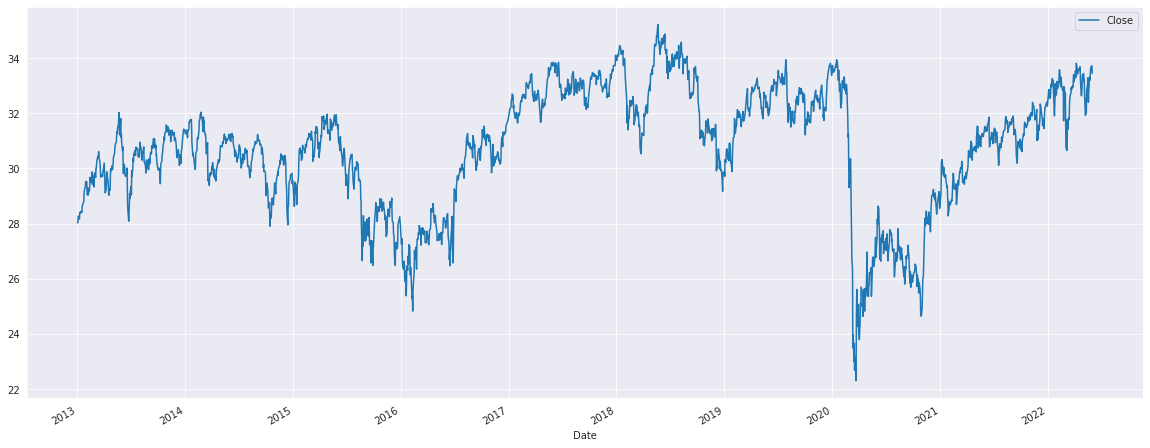

In [ ]:
ts=df[['Close']]
print(type(ts))
ts.plot(figsize=(20,8))

In [ ]:
ts.describe()

Close
count  2381.000000
mean     30.737955
std       2.179700
min      22.309999
25%      29.605000
50%      31.010000
75%      32.445000
max      35.215000

In [ ]:
ts.iloc[np.argmax(ts),:]

Close    35.215
Name: 2018-05-22 00:00:00, dtype: float64

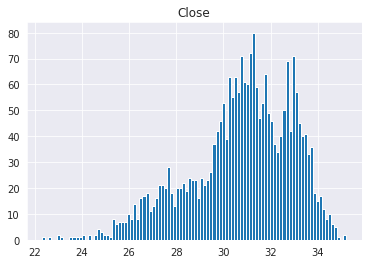

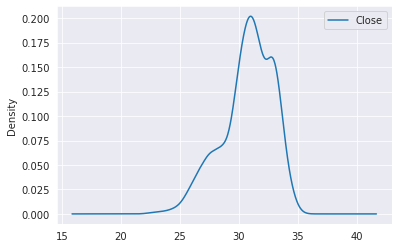

In [ ]:
ts.hist(bins=100)
ts.plot(kind='kde');

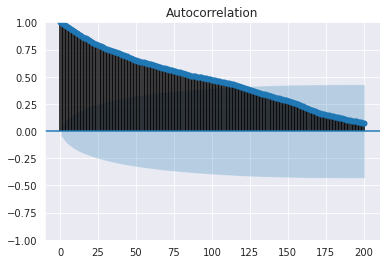

In [ ]:
# Quick check
plot_acf(ts, lags=200);

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


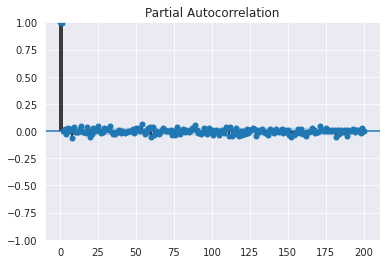

In [ ]:
plot_pacf(ts, lags=200);

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


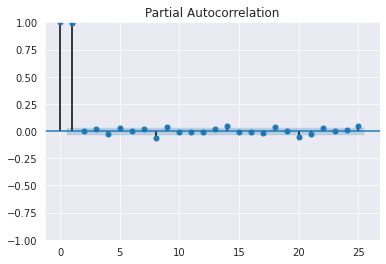

In [ ]:
plot_pacf(ts, lags=25);

## Set the frequency

In [ ]:
tsf=ts.asfreq('b');
#tsf=tsf.dropna()

tsf[tsf.isnull().any(axis=1)];

tsf.ffill(inplace=True);
display(tsf.head(15));
tsf.index       

Close
Date                 
2013-01-02  28.025000
2013-01-03  28.094999
2013-01-04  28.270000
2013-01-07  28.209999
2013-01-08  28.170000
2013-01-09  28.379999
2013-01-10  28.375000
2013-01-11  28.434999
2013-01-14  28.440001
2013-01-15  28.415001
2013-01-16  28.400000
2013-01-17  28.520000
2013-01-18  28.674999
2013-01-21  28.750000
2013-01-22  28.770000

DatetimeIndex(['2013-01-02', '2013-01-03', '2013-01-04', '2013-01-07',
               '2013-01-08', '2013-01-09', '2013-01-10', '2013-01-11',
               '2013-01-14', '2013-01-15',
               ...
               '2022-05-19', '2022-05-20', '2022-05-23', '2022-05-24',
               '2022-05-25', '2022-05-26', '2022-05-27', '2022-05-30',
               '2022-05-31', '2022-06-01'],
              dtype='datetime64[ns]', name='Date', length=2456, freq='B')

## Define the First difference: $X_t - X_{t-1}$

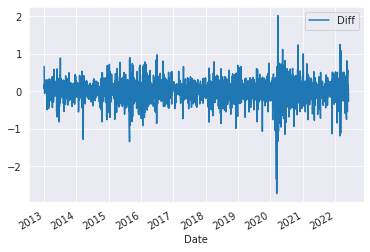

In [ ]:
# Is it a random walk?
diff=df[['Diff']]
diff.plot()

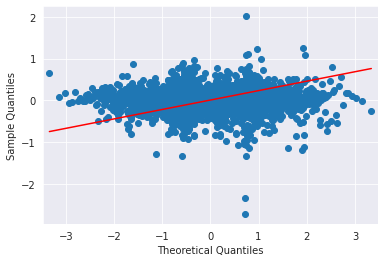

In [ ]:
sm.qqplot(diff, line='q');

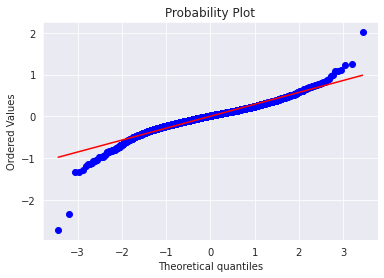

In [ ]:
plt.figure('QQ plot');
stats.probplot(diff['Diff'], plot=plt);


/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


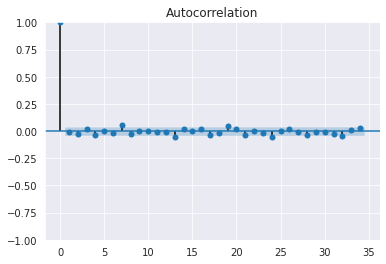

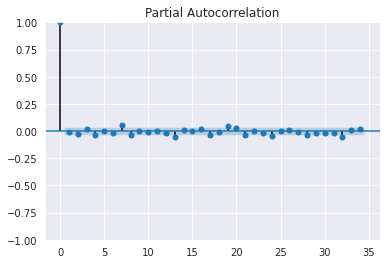

In [ ]:
plot_acf(diff)
plot_pacf(diff);

# I. Analysis of the time-series

## Seasonal decomposition (with the frequency set)

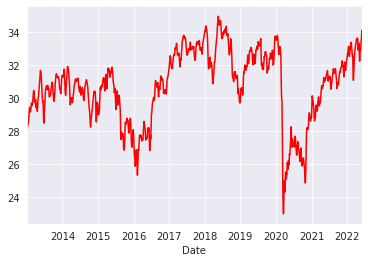

In [ ]:
ts_dec=seasonal_decompose(tsf,  extrapolate_trend = 'freq')
ts_dec.trend.plot(color='r');
plt.show()


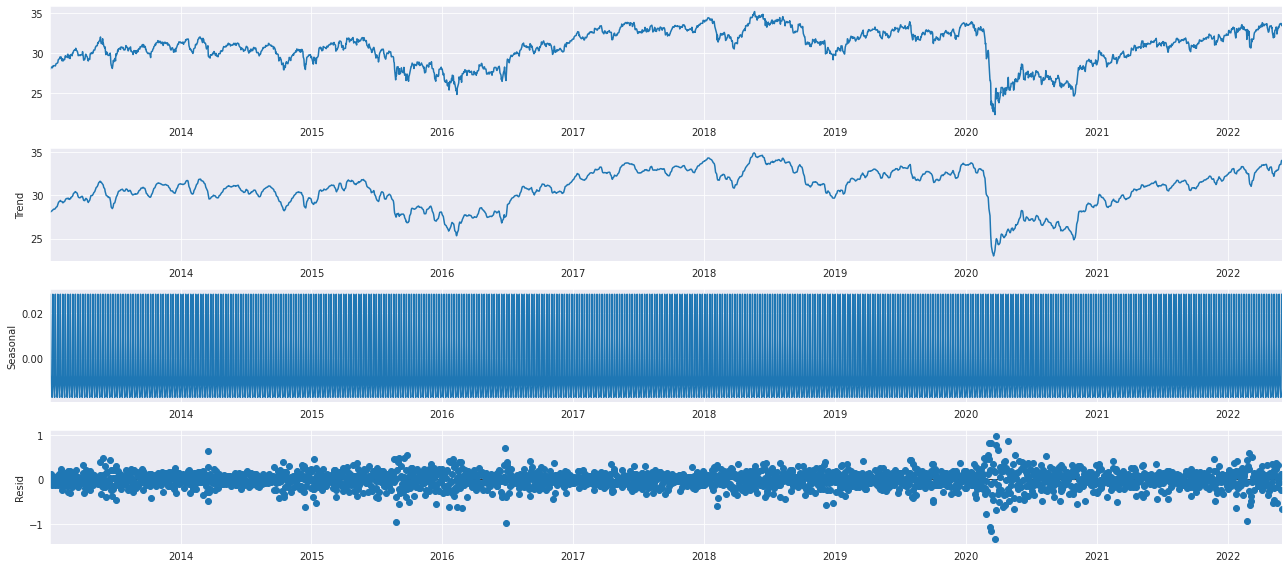

In [ ]:
pylab.rcParams['figure.figsize'] = (18, 8)
ts_dec.plot();


## FFT: Denoise the signal/time-series 

Apply Fast-Fourier Transform to denoise the time-series (just for the heck of it).


In [ ]:
tstrend=pd.DataFrame(ts_dec.trend)
tstrend

trend
Date                 
2013-01-02  28.066400
2013-01-03  28.116500
2013-01-04  28.154000
2013-01-07  28.225000
2013-01-08  28.281000
...               ...
2022-05-26  33.498000
2022-05-27  33.600999
2022-05-30  33.616000
2022-05-31  33.932399
2022-06-01  34.077599

[2456 rows x 1 columns]

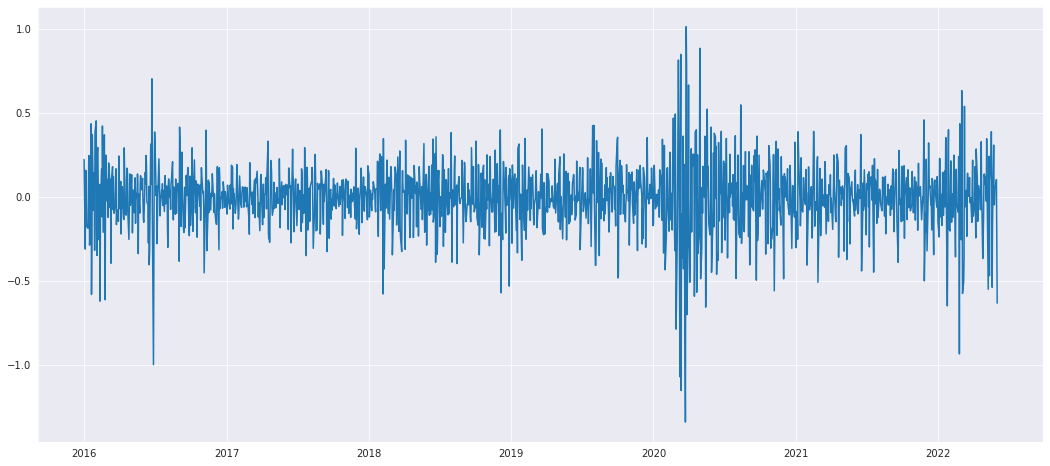

In [ ]:
ts_rest=tsf['Close']-tstrend['trend']
ts_rest=ts_rest['2016':]
plt.plot(ts_rest)
plt.show()

In [ ]:
ts_rest.isna().sum()

0

In [ ]:
'''
t=np.arange(0,len(ts_rest))
p=np.polyfit(t, ts_rest.values, 1)
ts_rest=ts_rest.values - p[0]*t -p[1]
plt.plot(ts_rest)
plt.show()
'''

'\nt=np.arange(0,len(ts_rest))\np=np.polyfit(t, ts_rest.values, 1)\nts_rest=ts_rest.values - p[0]*t -p[1]\nplt.plot(ts_rest)\nplt.show()\n'

In [ ]:
ts_rest.mean()

-0.0005854237692062092

In [ ]:
len(ts_rest)

1674

In [ ]:
# SAMPLE_RATE determines how many data points the signal uses to represent the sine wave per second. 
# So if the signal had a sample rate of 10 Hz and was a five-second sine wave, then it would have 10 * 5 = 50 data points.

# N=sample_rate * duration
#set N (window length)
N=int(len(ts_rest)    )
sample_rate=500 # Hertz=cycles per second (frequecy)

#set d (sample spacing) = inverse of the sampling rate
d=1/sample_rate

duration=  N*d  #seconds
print('Duration is {} second(s)'.format(duration))

ts_fft=fft(ts_rest.values)
ts_freq=fftfreq(N,  d)  # Return the Discrete Fourier Transform sample frequencies (sample frequency POINTS)
# If the sample spacing 'd' is in seconds then the frequency is cycles per second.

Duration is 3.348 second(s)


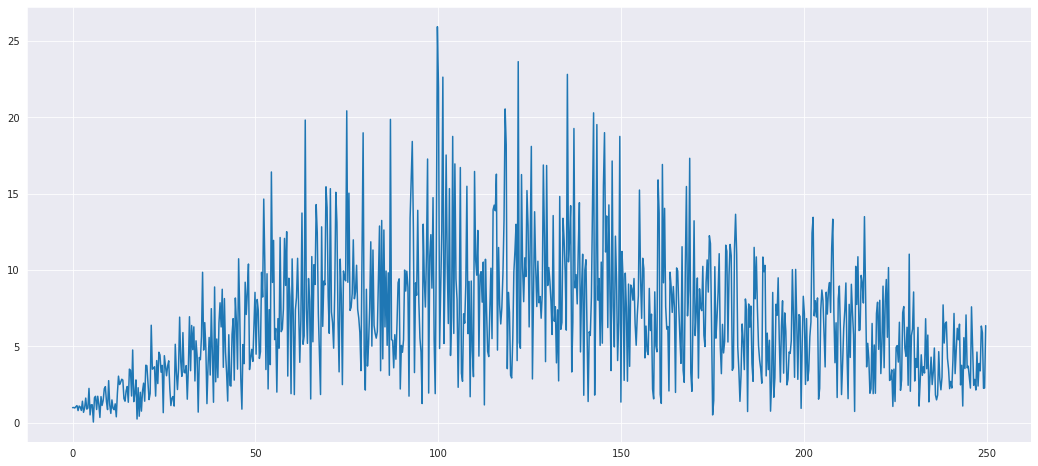

In [ ]:
plt.plot(ts_freq [:N//2] , np.abs(ts_fft[0:N//2]  ));
plt.show()

In [ ]:
sample_rate # 250-8000

500

In [ ]:
from scipy.io.wavfile import write

# Remember SAMPLE_RATE = 44100 Hz is our playback rate
write("mywave.wav", int(sample_rate), np.int16(ts_rest.values) )

The frequency spectrum that fft() outputted was reflected about the y-axis so that the negative half was a mirror of the positive half. This symmetry was caused by inputting real numbers (not complex numbers) to the transform.


The values returned by rfft() represent the power of each frequency bin. If you set the power of a given bin to zero, then the frequencies in that bin will no longer be present in the resulting time-domain signal.

Using the length of xf, the maximum frequency, and the fact that the frequency bins are evenly spaced, you can work out the target frequency’s index:

In [ ]:
target_freq=40
pts_per_freq=len(ts_freq)/ (sample_rate)
target_id=int(  pts_per_freq* target_freq)


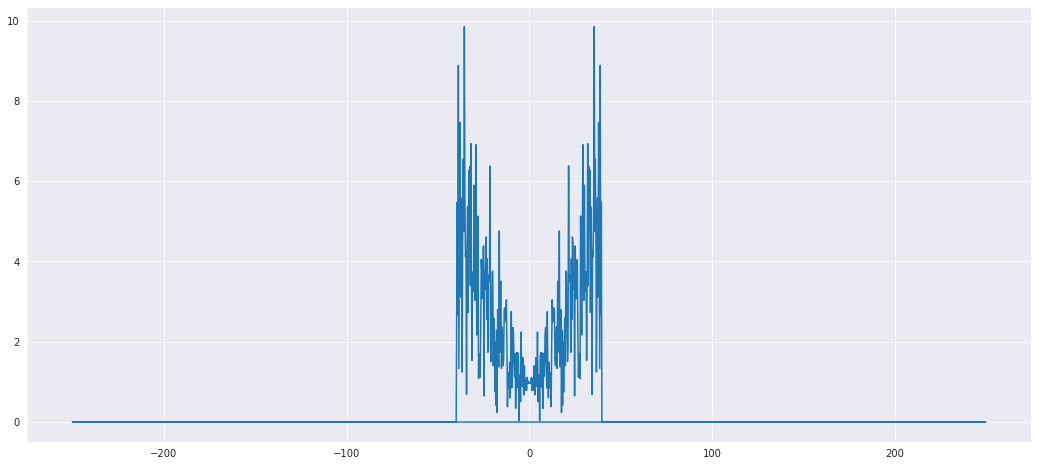

In [ ]:
ts_fft[target_id:-target_id]=0
#ts_fft[:N-target_freq:-1]=0
plt.plot(ts_freq,  np.abs(ts_fft));
plt.show()

In [ ]:
ts_ifft=ifft(ts_fft)

3348


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


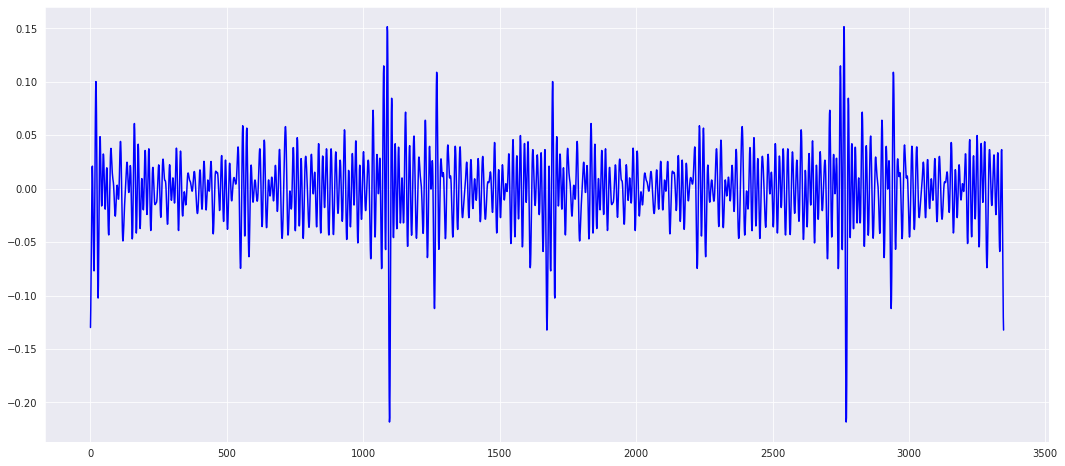

In [ ]:
#In case you want to do predictions extending the ifft
c=[*ts_ifft, *ts_ifft]
print( len(c) )
plt.plot( c, color='b',  label='IFFT' )
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


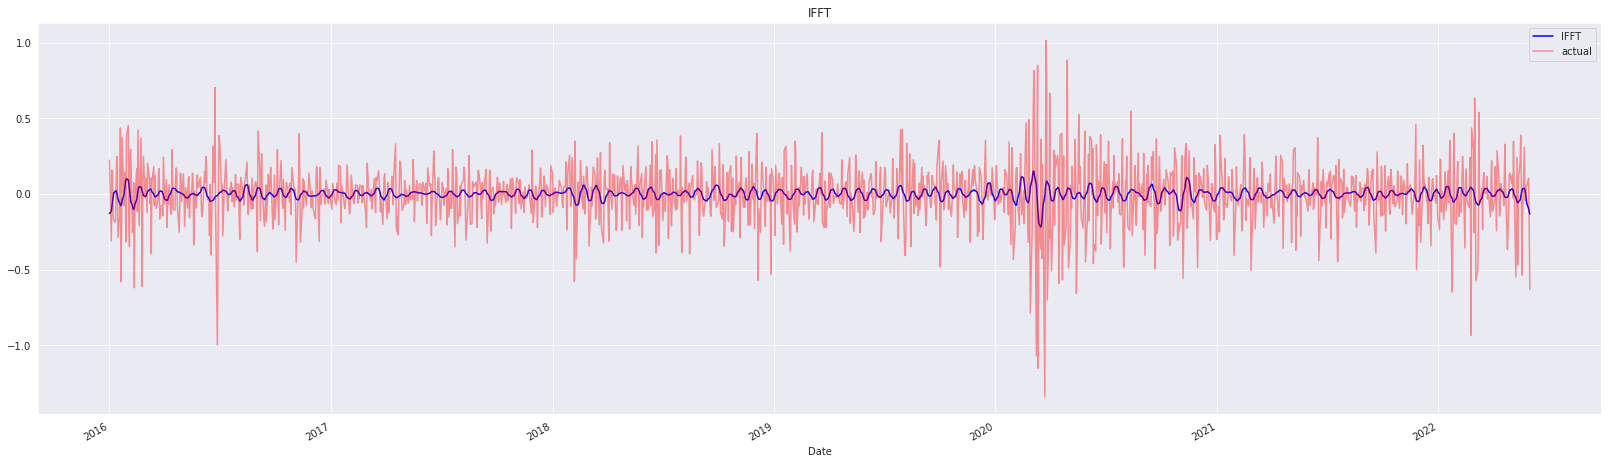

In [ ]:
plt.plot(ts_rest.index, ts_ifft, color='b',  label='IFFT' )
ts_rest.plot(color='r', figsize=(28,8), alpha=0.4,  label='actual')
plt.title('IFFT')
plt.legend(loc='best')
plt.show()


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


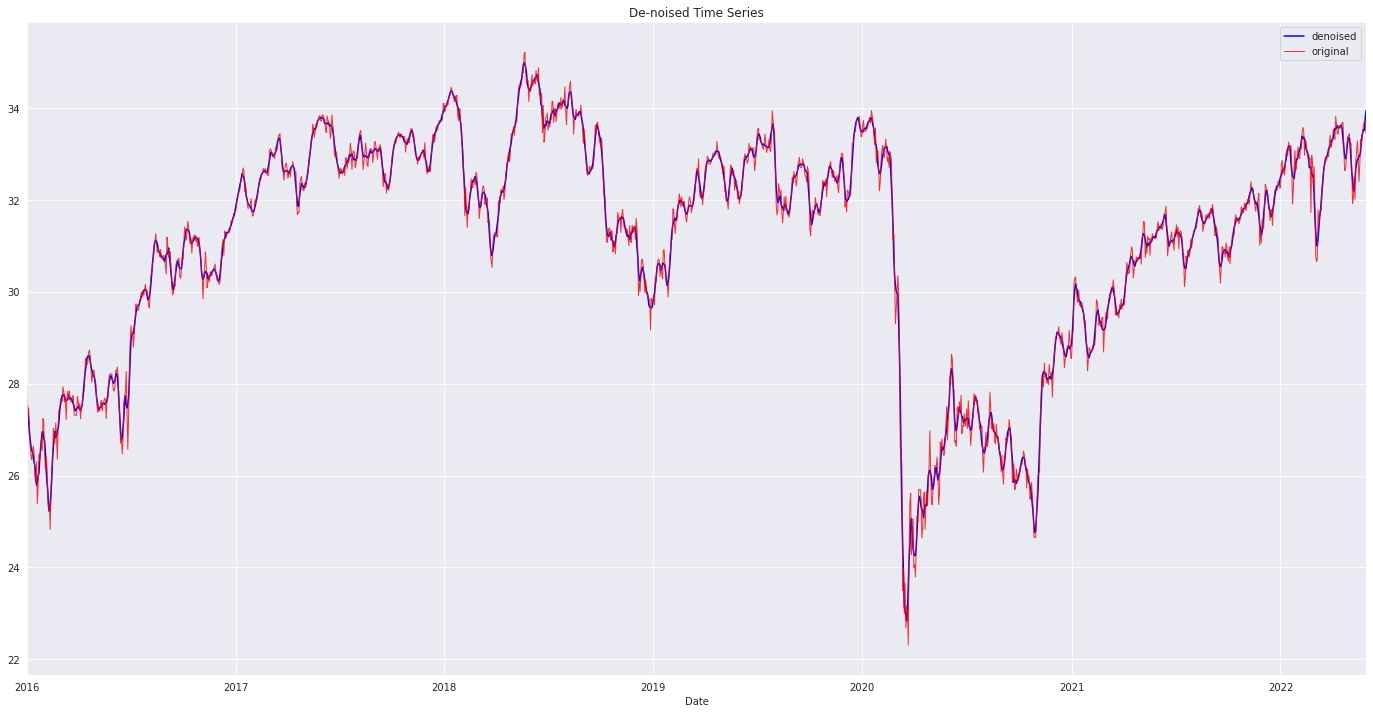

In [ ]:
a= ts_denoised=tstrend['trend']['2016':]+ts_ifft
b= tsf['Close']['2016':]
a.plot(color='b', label='denoised',  figsize=(24,12), animated=True)
b.plot(color='r',linestyle='-', lw=1,  alpha=0.8, label='original')
plt.title('De-noised Time Series')
plt.legend(loc='best')
plt.show()

## Simple Moving Average (SMA)

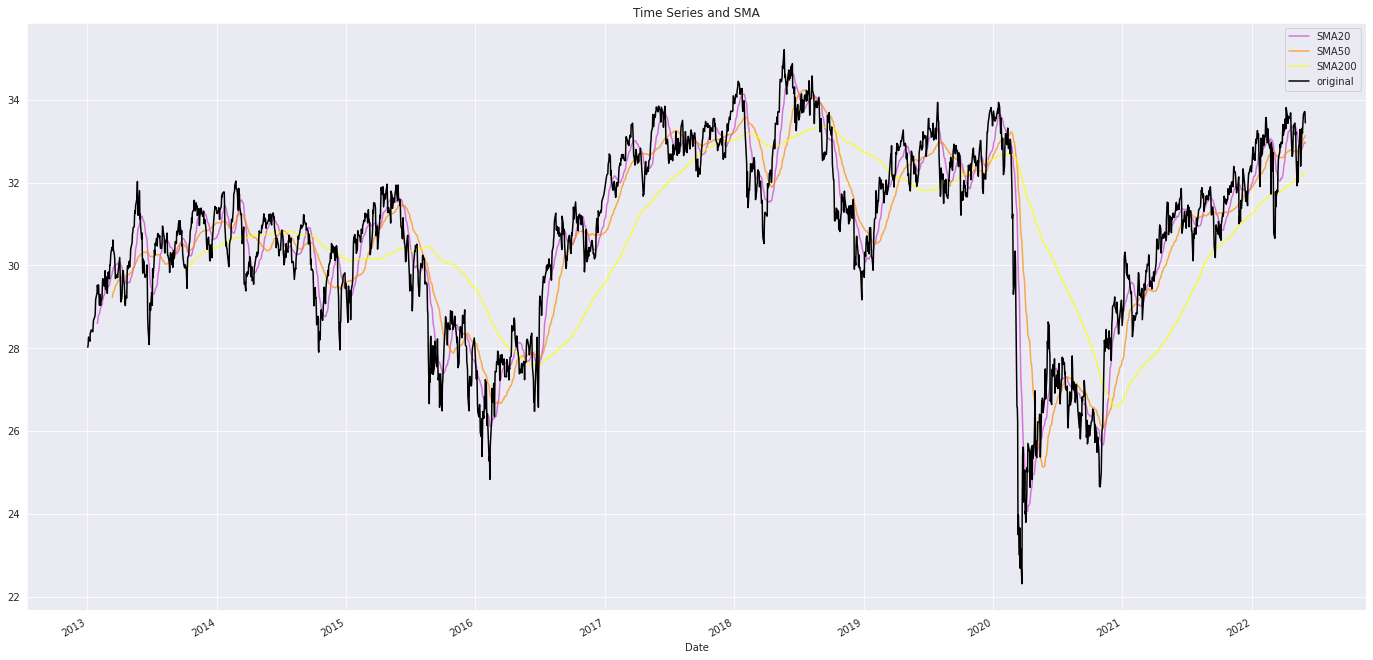

In [ ]:
sma={}
for k in [20, 50, 200]:
    sma[k]=ts.rolling(k).mean()

plt.figure()
sma[20]['Close'].plot(color='m', label='SMA20',  figsize=(24,12),alpha=0.5,  animated=True)
sma[50]['Close'].plot(color='darkorange', label='SMA50', alpha=0.7,  animated=True)
sma[200]['Close'].plot(color='yellow', label='SMA200',alpha=0.7,    animated=True)
ts['Close'].plot(color='black',   alpha=1, label='original')
plt.title('Time Series and SMA')
plt.legend(loc='best')
plt.show()

## Stationarity: quick check

In [ ]:
result = adfuller(ts)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -3.291466
p-value: 0.015264
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


In [ ]:
result = adfuller(diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -17.384315
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


The time-series $X_t$ and the difference time series $X_t - X_{t-1}$ are stationary (no unit root is present).

## ARIMA



**Use auto_arima to find the optimal hyperparameters p,d,q**

In [ ]:
results={}

In [ ]:
model = pm.auto_arima(ts, start_p=1, start_q=1, 
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                   #   d=0,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                  #    D=0, 
                  #    information_criterion='aic', # default, (‘aic’, ‘bic’, ‘hqic’, ‘oob’
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=939.696, Time=1.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=935.745, Time=0.69 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=937.457, Time=0.36 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=937.443, Time=0.80 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=933.887, Time=0.23 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.176 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2381
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -465.944
Date:                Mon, 06 Jun 2022   AIC                            933.887
Time:                        15:22:35   BIC                            939.662
Sample:                             0   HQIC                           935.989
                               - 2381                                         
Co

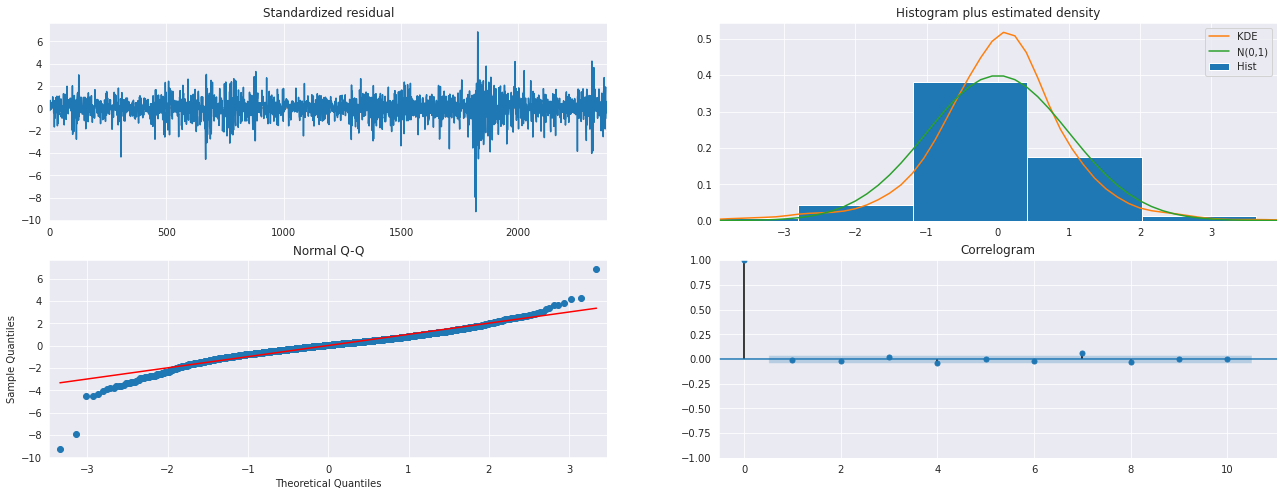

In [ ]:
model.plot_diagnostics(figsize=(22,8))
plt.show()

**Remark**: Essentially, we have that $X_t=X_{t-1}+\epsilon_t$ where $\epsilon_t \sim N(0, \sigma^2)$ with $\sigma^2=$sigma2.

In [ ]:
# Try it, fit model
model_1 =  sm.tsa.statespace.SARIMAX(ts, order=(0,1,0))
model_fit = model_1.fit(return_params=0)
# summary of fit model
print(model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2381
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -465.944
Date:                Mon, 06 Jun 2022   AIC                            933.887
Time:                        15:22:37   BIC                            939.662
Sample:                             0   HQIC                           935.989
                               - 2381                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0866      0.001     73.971      0.000       0.084       0.089
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):              5371.45
Prob(Q):                              0.59   Pr

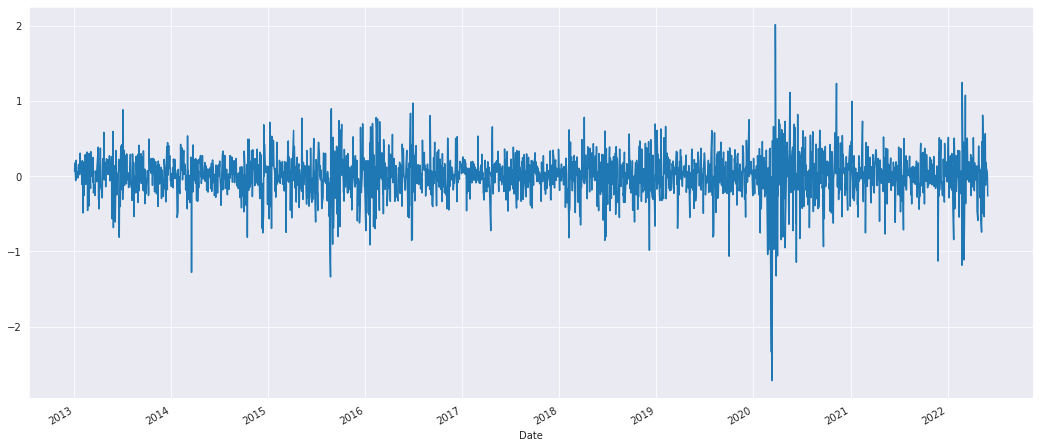

In [ ]:
residuals= model_fit.resid[1:]
plt.figure()

residuals.plot();

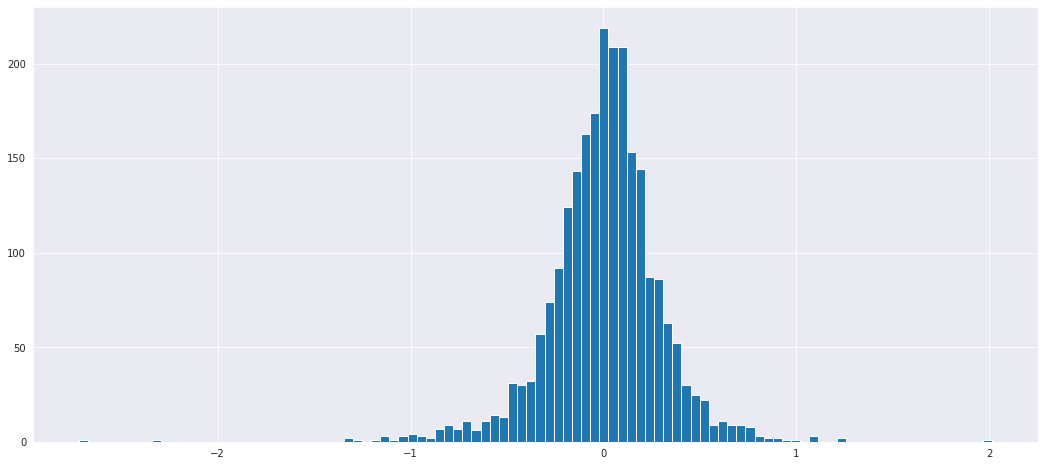

In [ ]:
plt.figure()
residuals.hist(bins=100);

In [ ]:
residuals.describe()

count    2380.000000
mean        0.002277
std         0.294351
min        -2.719999
25%        -0.144999
50%         0.015002
75%         0.160000
max         2.015001
dtype: float64

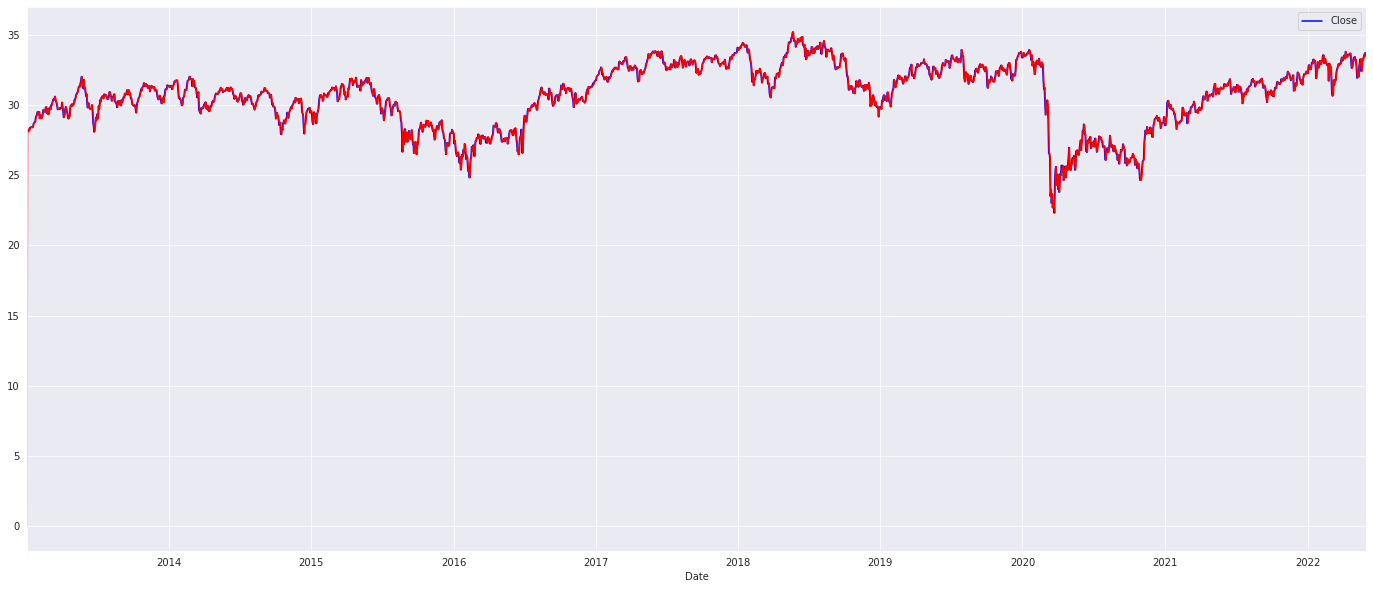

In [ ]:
# Actual vs Fitted
tsf.plot(color='b', label='actual');
model_fit.predict().plot(figsize=(24,10), color='r', label='ARIMA')
plt.show()

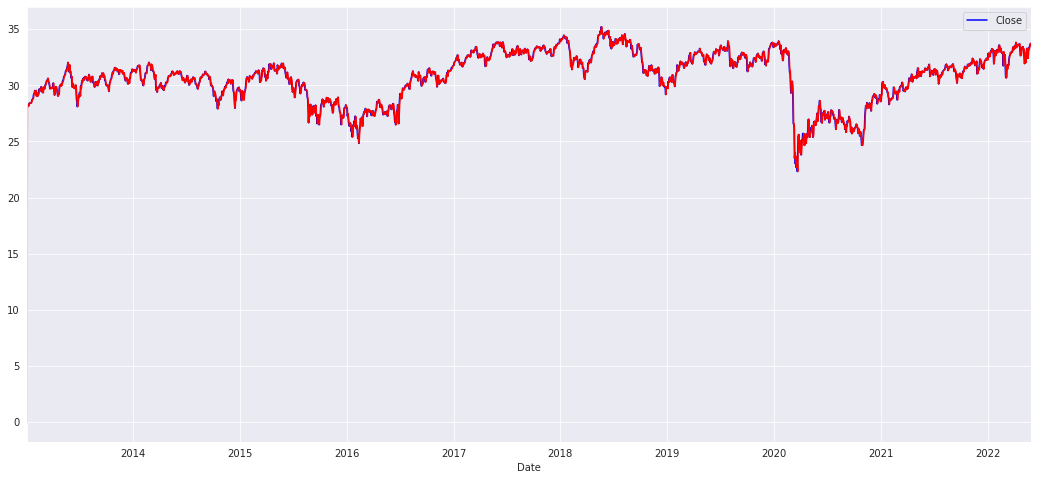

In [ ]:
# Alternative way to plot them

tsf.plot(color='b', label='actual');
model_fit.fittedvalues.plot(color='r');
plt.show();

**MSE and MAE**

In [ ]:
# evaluate forecasts
mse = (mean_squared_error(ts, model_fit.predict()  ))
print('Test MSE: %.3f' % mse)

mae = (mean_absolute_error(ts, model_fit.predict()  ))
print('Test MAE: %.3f' % mae)

Test MSE: 0.416
Test MAE: 0.220


## ARIMA for log returns, $\log X_t$

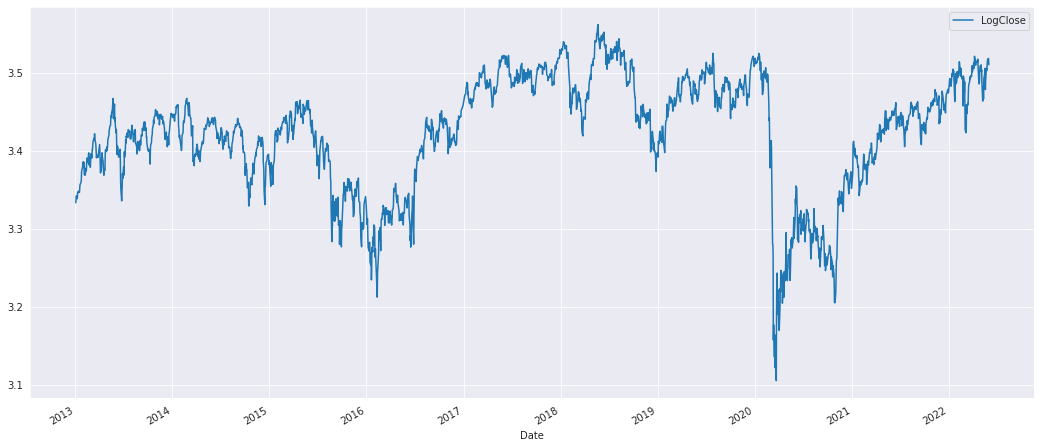

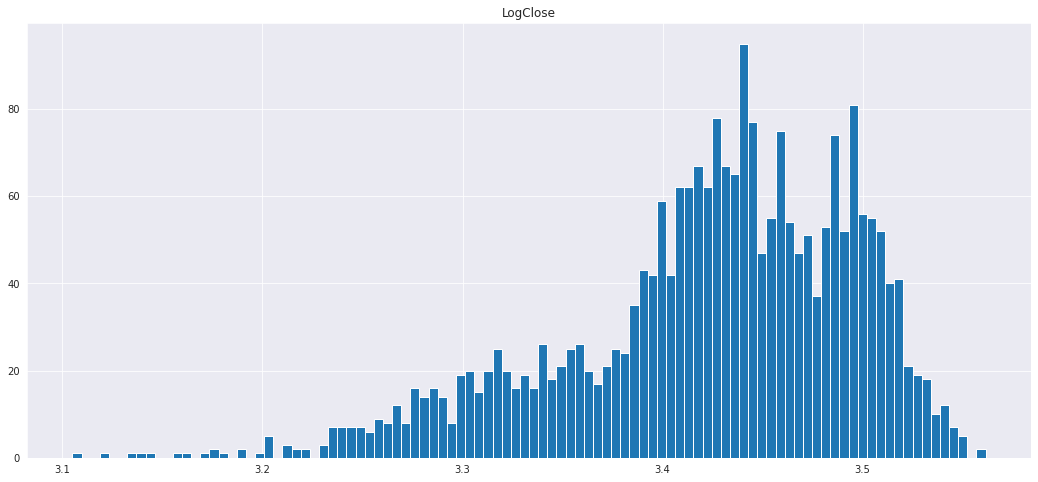

In [ ]:
logts=df[['LogClose']];
logts.plot();
logts.hist(bins=100);

In [ ]:
logts.describe()

LogClose
count  2381.000000
mean      3.422882
std       0.073120
min       3.105035
25%       3.387943
50%       3.434310
75%       3.479546
max       3.561472

In [ ]:
logtsf=logts.asfreq('b');

logtsf[logtsf.isnull().any(axis=1)];

logtsf.ffill(inplace=True);
display(logtsf.head(15));
logtsf.index        #ts.unstack().values

#pd.Series(ts.unstack().values)

LogClose
Date                
2013-01-02  3.333097
2013-01-03  3.335592
2013-01-04  3.341801
2013-01-07  3.339676
2013-01-08  3.338258
2013-01-09  3.345685
2013-01-10  3.345508
2013-01-11  3.347621
2013-01-14  3.347797
2013-01-15  3.346917
2013-01-16  3.346389
2013-01-17  3.350606
2013-01-18  3.356026
2013-01-21  3.358638
2013-01-22  3.359333

DatetimeIndex(['2013-01-02', '2013-01-03', '2013-01-04', '2013-01-07',
               '2013-01-08', '2013-01-09', '2013-01-10', '2013-01-11',
               '2013-01-14', '2013-01-15',
               ...
               '2022-05-19', '2022-05-20', '2022-05-23', '2022-05-24',
               '2022-05-25', '2022-05-26', '2022-05-27', '2022-05-30',
               '2022-05-31', '2022-06-01'],
              dtype='datetime64[ns]', name='Date', length=2456, freq='B')

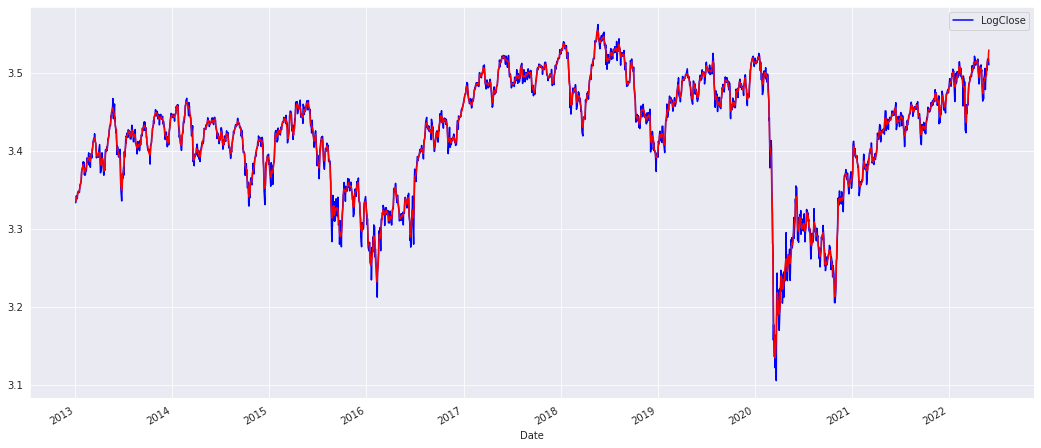

In [ ]:
logts_dec=seasonal_decompose(logtsf,  extrapolate_trend = 'freq')

logts.plot(color='b');
logts_dec.trend.plot(color='r');
plt.show()


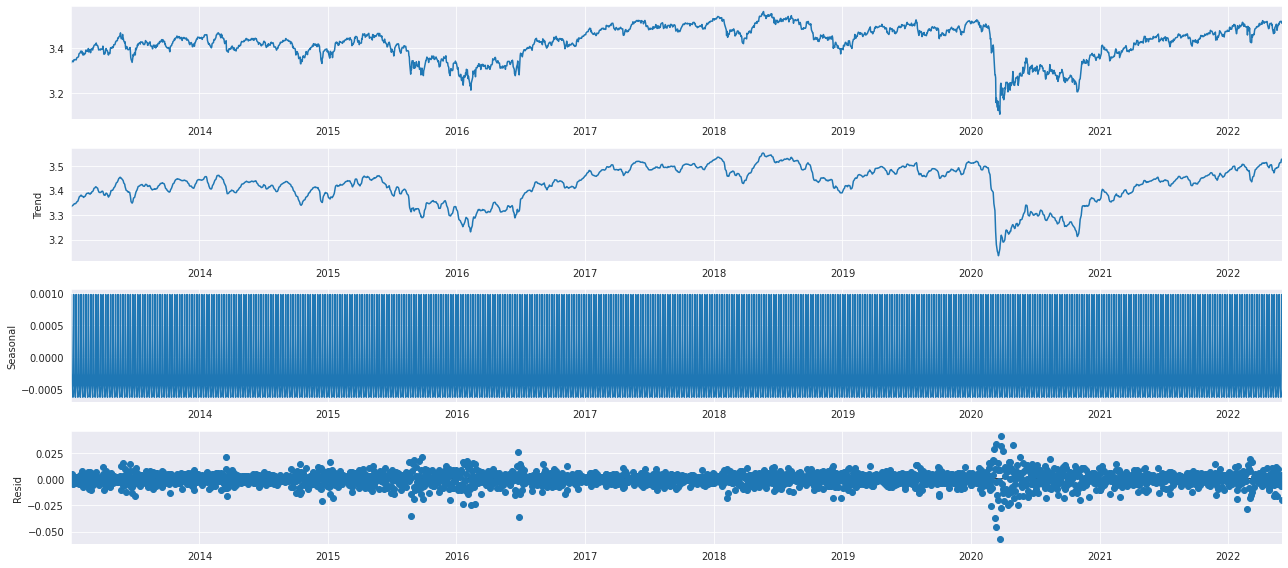

In [ ]:
logts_dec.plot();

### Difference of the logs

LogDiff
count  2381.000000
mean      0.000084
std       0.010193
min      -0.109522
25%      -0.004705
50%       0.000527
75%       0.005150
max       0.086470

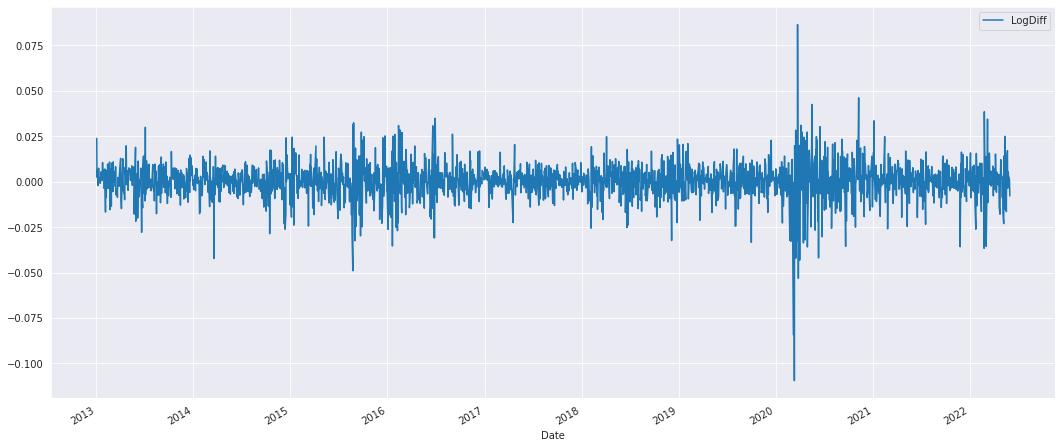

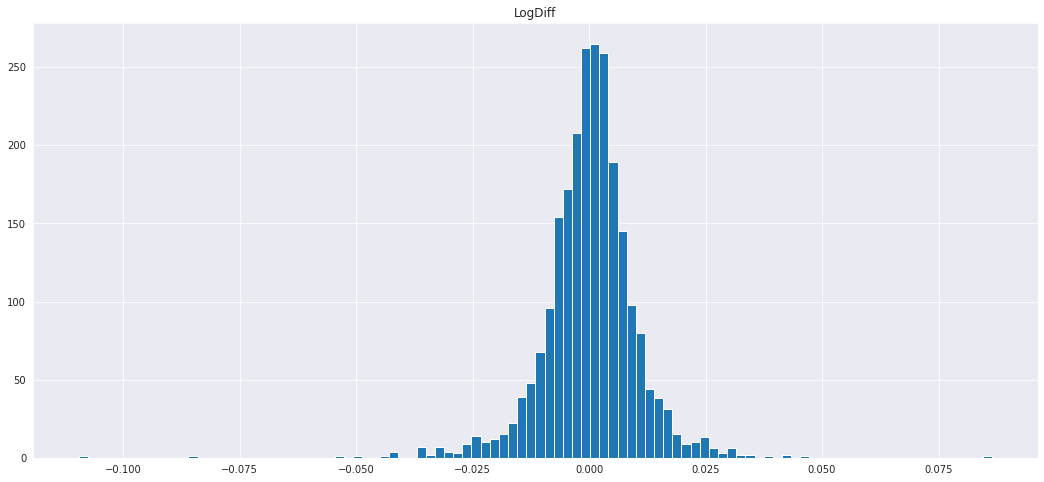

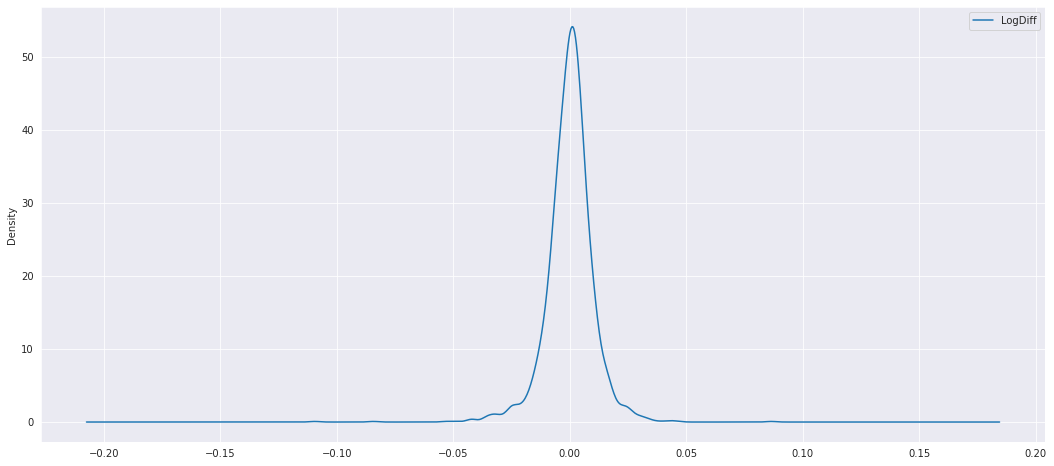

In [ ]:
# This is the difference of the logs, i.e. the r's

logdiff=df[['LogDiff']];
logdiff.plot()
logdiff.hist(bins=100);
logdiff.plot(kind='kde')
logdiff.describe()

In [ ]:
result = adfuller(logdiff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -11.083518
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


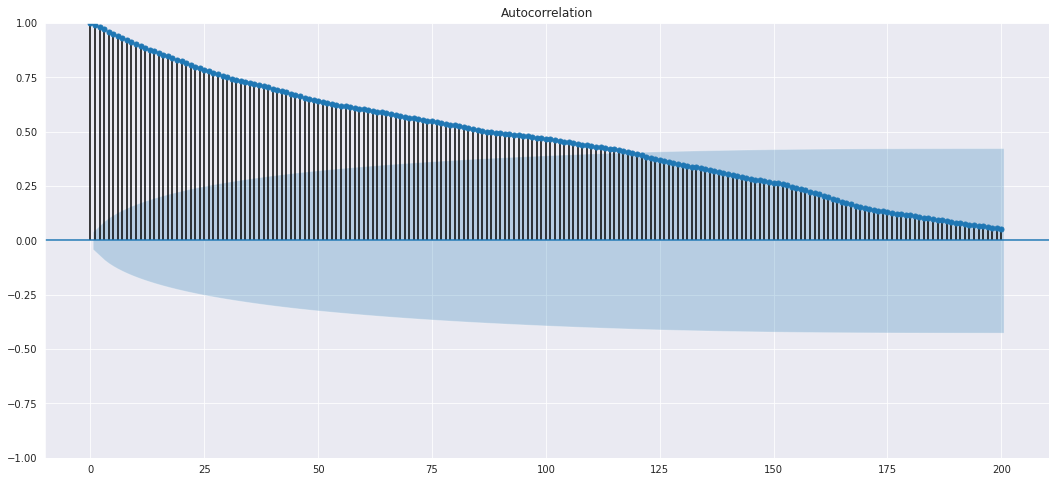

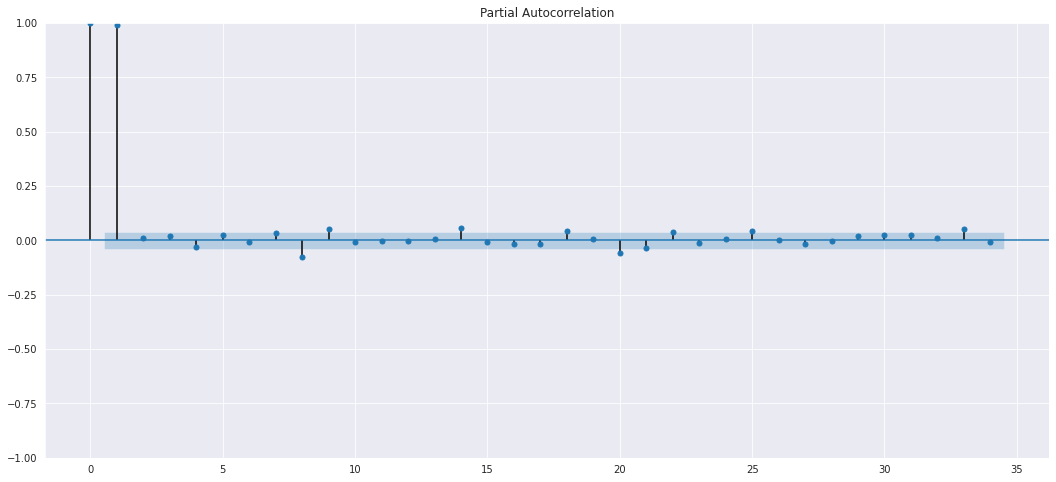

In [ ]:
plot_acf(logts, lags=200)
plot_pacf(logts);

**Apply auto_arima to the log returns**

In [ ]:
model_ld = pm.auto_arima(logts, start_p=1, start_q=1, 
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=4, max_q=4, # maximum p and q
                      m=1,              # frequency of series
                      #d=1,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      #D=0, 
                      information_criterion='aic', # default, (‘aic’, ‘bic’, ‘hqic’, ‘oob’
                     # trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_ld.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2381
Model:               SARIMAX(0, 1, 0)   Log Likelihood                7540.444
Date:                Mon, 06 Jun 2022   AIC                         -15078.887
Time:                        15:22:59   BIC                         -15073.112
Sample:                             0   HQIC                        -15076.785
                               - 2381                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0001   1.15e-06     90.444      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.89   Jarque-Bera (JB):             13977.76
Prob(Q):                              0.35   Pr

 **This means that  $\log X_t - \log X_{t-1} = \epsilon_t, \text{where  } \epsilon_t \sim  \mathcal{N}(0, coef) $** 

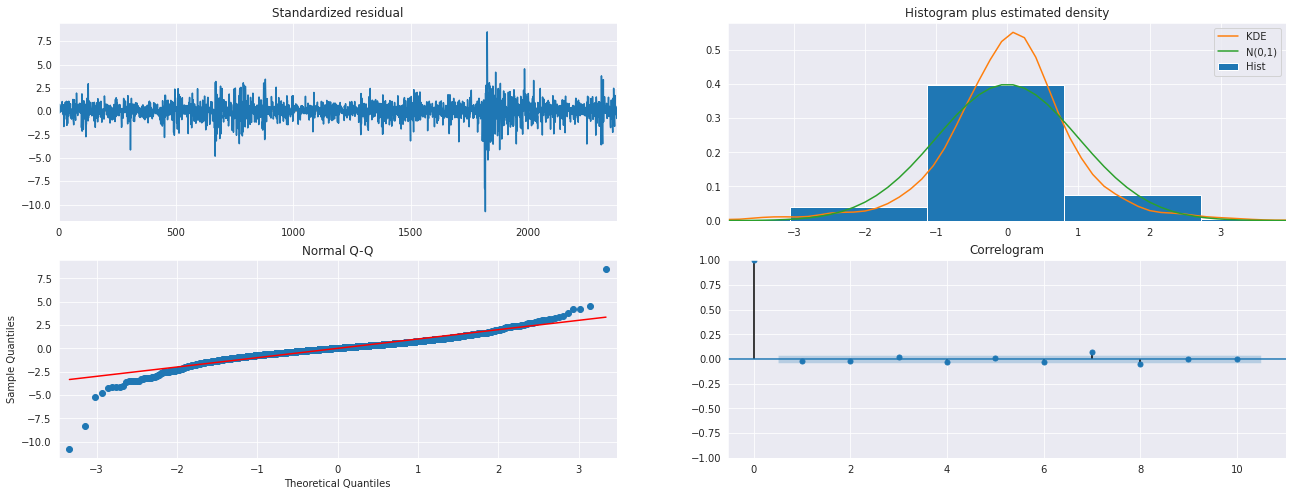

In [ ]:
model_ld.plot_diagnostics(figsize=(22,8))
plt.show()

In [ ]:
# fit model

#model_ld_1 = model_ld  
model_ld_1 =  sm.tsa.statespace.SARIMAX(logts, order=(0,1,0))
model_fit_ld = model_ld_1.fit(  return_params=0)



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
# summary of fit model
print(model_fit_ld.summary())

                               SARIMAX Results                                
Dep. Variable:               LogClose   No. Observations:                 2381
Model:               SARIMAX(0, 1, 0)   Log Likelihood                7540.444
Date:                Mon, 06 Jun 2022   AIC                         -15078.887
Time:                        15:23:01   BIC                         -15073.112
Sample:                             0   HQIC                        -15076.785
                               - 2381                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0001   1.15e-06     90.444      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.89   Jarque-Bera (JB):             13977.76
Prob(Q):                              0.35   Pr

In [ ]:
model_fit_ld.predict()

Date
2013-01-02    0.000000
2013-01-03    3.333097
2013-01-04    3.335592
2013-01-07    3.341801
2013-01-08    3.339676
                ...   
2022-05-26    3.507657
2022-05-27    3.513037
2022-05-30    3.516162
2022-05-31    3.518091
2022-06-01    3.517795
Name: predicted_mean, Length: 2381, dtype: float64

**MSE and MAE**

In [ ]:
# evaluate forecasts
mse_ld = mean_squared_error(ts, np.exp( model_fit_ld.predict()  )  )
print('Test MSE: %.3f' % mse_ld)

mae_ld = mean_absolute_error(ts, np.exp( model_fit_ld.predict()  ))
print('Test MAE: %.3f' % mae_ld)

Test MSE: 0.393
Test MAE: 0.219


## GARCH

In [ ]:
am = arch_model(ts)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     37,   Neg. LLF: 4050.4061925777078
Iteration:     10,   Func. Count:     72,   Neg. LLF: 3932.4463028639743
Iteration:     15,   Func. Count:    106,   Neg. LLF: 3910.732037848239
Iteration:     20,   Func. Count:    137,   Neg. LLF: 3904.408752872677
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3904.339309336762
            Iterations: 24
            Function evaluations: 162
            Gradient evaluations: 24
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3904.34
Distribution:                  Normal   AIC:                           7816.68
Method:            Maximum Likelihood   BIC:                           7839.78
                         

This is $GARCH(1,1):$

$$  r_t = \mu+ e_t$$

$$\sigma_t^2 = \omega + \alpha_1 \epsilon_{t-1}^2 + \beta_1 \sigma_{t-1}^2$$

$$\epsilon_t = \sigma_t e_t,\;\; e_t \sim N(0,1) $$

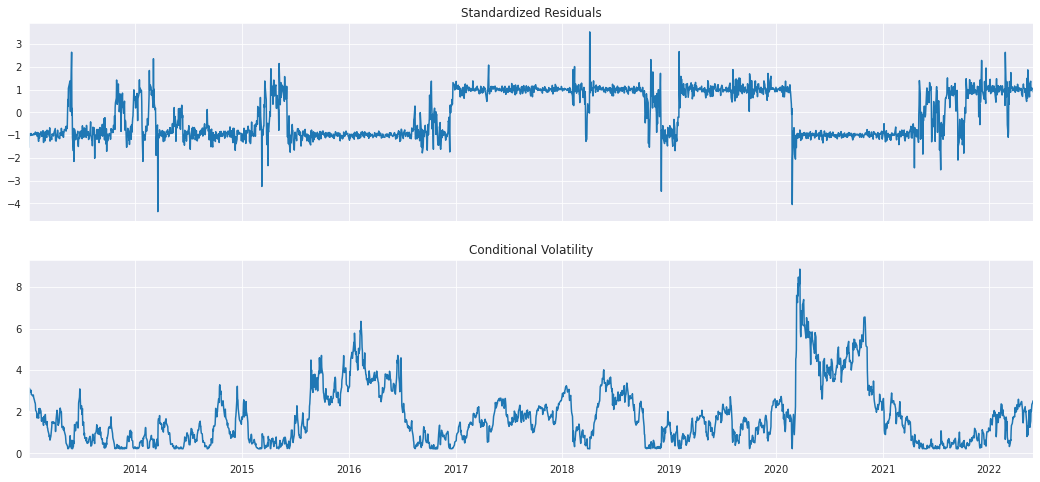

In [ ]:
garcgfig=res.plot()

# II. Forecasting and Backtesting

## Split the dataset: Train/test set  

In [ ]:
# split into train and test sets

split='2022-01'

ts_recent= (  tsf['2010':])
ts_train=ts_recent[:split]
ts_test=ts_recent[ts_train.index[-1]+timedelta(days=1):]
ts_test

Close
Date                 
2022-02-01  32.985001
2022-02-02  33.154999
2022-02-03  32.950001
2022-02-04  32.900002
2022-02-07  33.130001
...               ...
2022-05-26  33.549999
2022-05-27  33.654999
2022-05-30  33.720001
2022-05-31  33.709999
2022-06-01  33.445000

[87 rows x 1 columns]

## Naive Forecasting (our baseline)

In [ ]:
diff['2022-2':]

Diff
Date                
2022-02-01  0.275002
2022-02-02  0.169998
2022-02-03 -0.204998
2022-02-04 -0.049999
2022-02-07  0.230000
...              ...
2022-05-26  0.180000
2022-05-27  0.105000
2022-05-30  0.065002
2022-05-31 -0.010002
2022-06-01 -0.264999

[84 rows x 1 columns]

In [ ]:
mae=diff['2022-2':].abs().mean()
mae=mae['Diff']
mae

0.27482128143310547

In [ ]:
mse=diff['2022-2':].pow(2).mean()
mse=mse['Diff']
mse

0.15061626999461927

In [ ]:
results['Naive* (daily updated)']=[mae, mse]

**Our Baseline**: Forecasting the whole 4-month period at once

In [ ]:
naive_error=ts_test-ts_train['Close'][-1]
naive_mae=naive_error.abs().mean()
naive_mse=naive_error.pow(2).mean()
results['Naive (Baseline)']=[float(naive_mae), float(naive_mse)]

# ARIMA predictions


In [ ]:
model_tt = pm.auto_arima(ts_train, start_p=0, start_q=0, 
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=4, max_q=4, # maximum p and q
                     # m=1,              # frequency of series
                      #d=1,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      #start_P=0, 
                      #D=0, 
                      information_criterion='aic', # default, (‘aic’, ‘bic’, ‘hqic’, ‘oob’
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_tt.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=793.054, Time=0.36 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=795.033, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=795.032, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=791.168, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=788.708, Time=2.63 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=789.231, Time=3.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=789.261, Time=2.38 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=796.422, Time=0.93 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=796.444, Time=0.64 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=791.763, Time=2.33 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=786.820, Time=1.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=793.146, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=793.147, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=787.349, Time=0.69 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=787.3

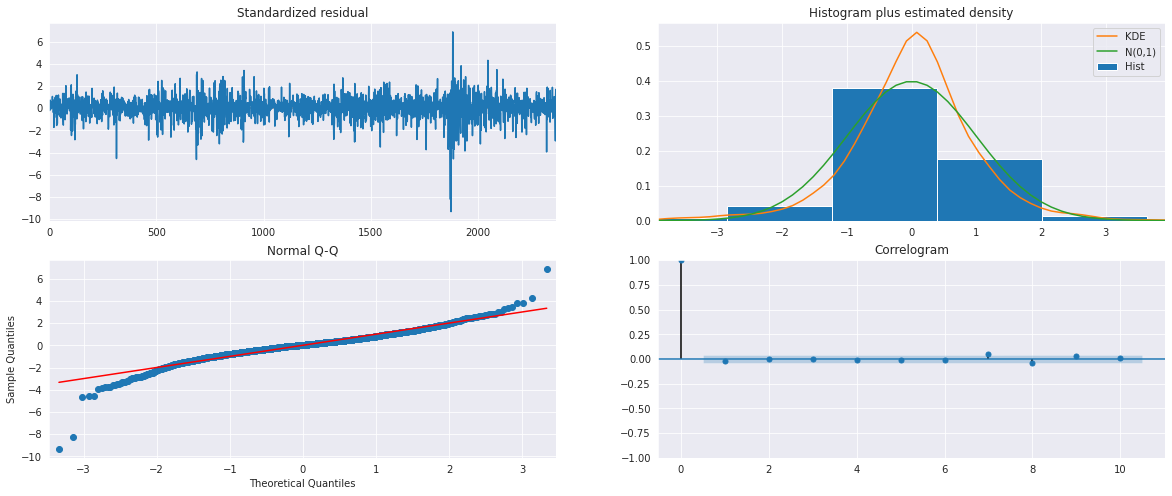

In [ ]:
model_tt.plot_diagnostics(figsize=(20,8))
plt.show()

In [ ]:
# fit model
model_tt_1 =  sm.tsa.statespace.SARIMAX(ts_train,order=(1,1,1) # order=(0,1,0) 
                                        #, seasonal_order=(4,1,2,5)
                                        )
model_tt_fit = model_tt_1.fit( return_params=0, disp=-1)
# summary of fit model
print(model_tt_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2369
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -390.410
Date:                Mon, 06 Jun 2022   AIC                            786.820
Time:                        15:23:22   BIC                            804.129
Sample:                    01-02-2013   HQIC                           793.121
                         - 01-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9246      0.038    -24.029      0.000      -1.000      -0.849
ma.L1          0.9473      0.034     27.761      0.000       0.880       1.014
sigma2         0.0814      0.001     69.406      0.0

In [ ]:
#fc=model_tt_fit.predict( start=ts_train.index[-1]+ timedelta(days=1) , end=ts_test.index[-1] , alpha=0.05)
fc=model_tt_fit.predict( start=ts_test.index[0], end=ts_test.index[-1] , dynamic=True, alpha=0.05)

#fc=model_tt_fit.forecast( len(ts_test) )

#Forecast=model_tt_fit.predict(start=len(ts_train), 
                           # end=len(ts_train)+len(ts_test)-1, dynamic=True)
fc.head()

2022-02-01    32.735807
2022-02-02    32.711946
2022-02-03    32.734007
2022-02-04    32.713610
2022-02-07    32.732469
Freq: B, Name: predicted_mean, dtype: float64

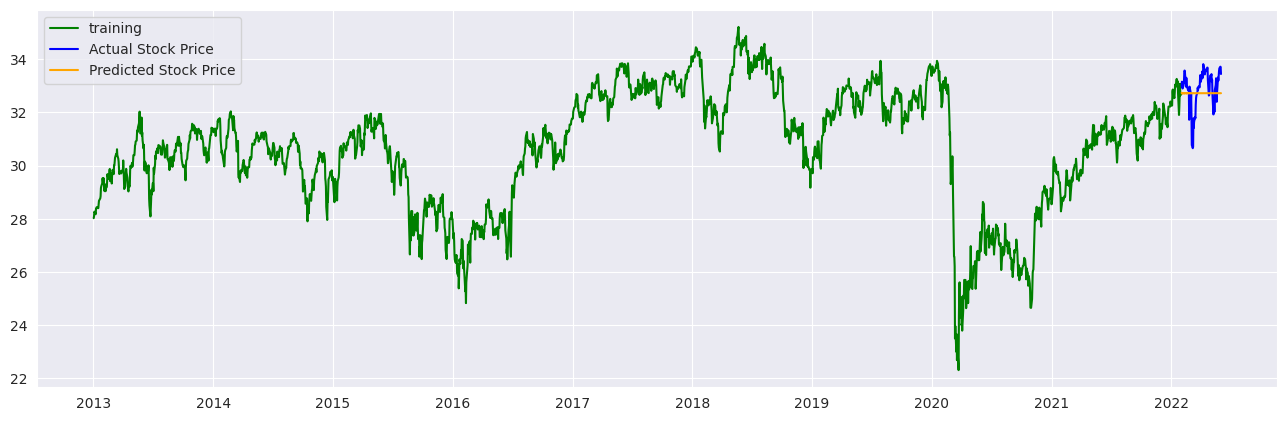

In [ ]:
plt.figure(figsize=(16,5), dpi=100)
plt.plot( (ts_train), color='green', label='training')
plt.plot( (ts_test), color = 'blue', label='Actual Stock Price')
plt.plot( fc, color = 'orange',label='Predicted Stock Price')
plt.legend(loc='best')

plt.show()

**MSE and MAE**

In [ ]:
# report performance
mse = mean_squared_error(ts_test, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(ts_test, fc)
print('MAE: '+str(mae))
rmse = np.sqrt(mean_squared_error(ts_test, fc))
print('RMSE: '+str(rmse))

results['ARIMA(1,1,1)']=[mae, mse]

MSE: 0.5051752654198782
MAE: 0.5769197025370499
RMSE: 0.7107568257990058


# Triple Exponential Smoothing

In [ ]:
triple_xs=ExponentialSmoothing(ts_train,  seasonal_periods=5 ,trend='add' , seasonal='mul'
                               ,use_boxcox=True
                               ,initialization_method="estimated"
                              ).fit(optimized=True)

triple_xs.params

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


{'damping_trend': nan,
 'initial_level': 558883.188344781,
 'initial_seasons': array([0.99312175, 0.99923547, 1.01104836, 1.0002932 , 0.99630122]),
 'initial_trend': 3589.8673090263037,
 'lamda': 4.410034911466553,
 'remove_bias': False,
 'smoothing_level': 0.995,
 'smoothing_seasonal': 0.0050000000000000044,
 'smoothing_trend': 0.0001,
 'use_boxcox': True}

In [ ]:
fc_xs=triple_xs.predict( start=ts_test.index[0], end=ts_test.index[-1])

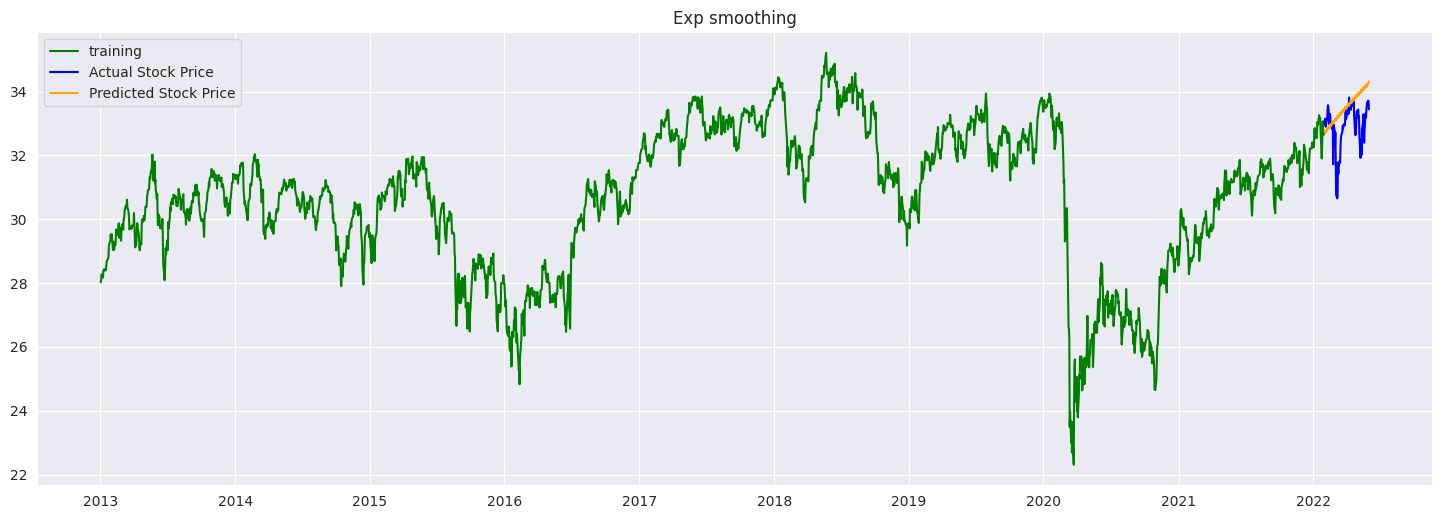

In [ ]:
plt.figure(figsize=(18,6), dpi=100)
plt.plot( (ts_train), color='green', label='training')
plt.plot( (ts_test), color = 'blue', label='Actual Stock Price')
plt.plot( fc_xs, color = 'orange',label='Predicted Stock Price')
plt.title('Exp smoothing')
plt.legend(loc='best')
plt.show()

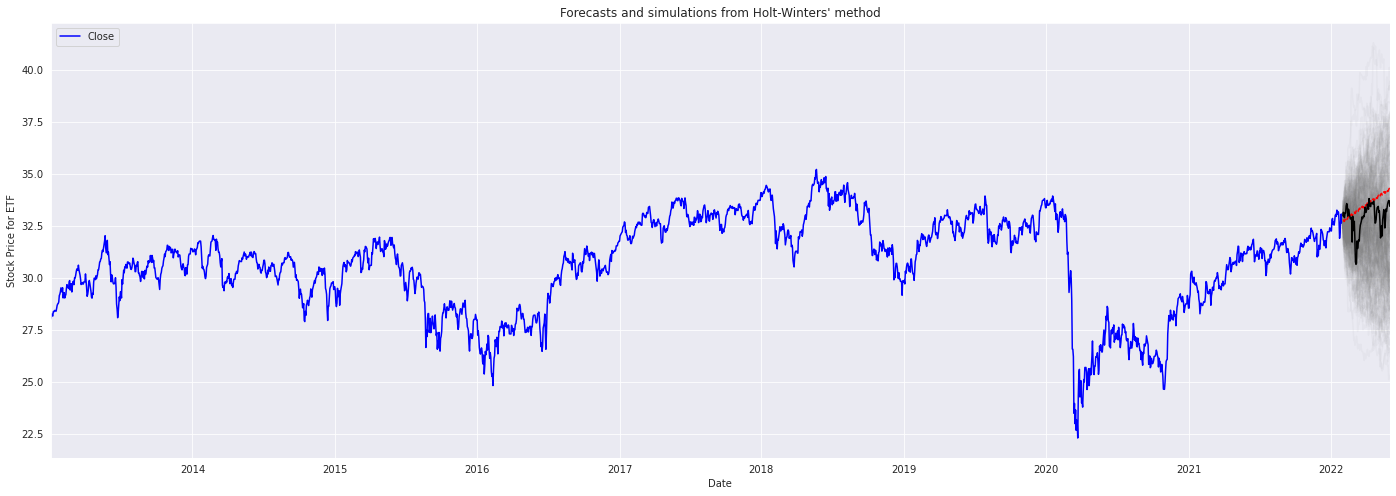

In [ ]:
simulations=triple_xs.simulate(len(ts_test), repetitions=300, error='mul',  random_errors='bootstrap')

company='ETF'

ax=ts_train.plot(figsize=(24,8), color='blue', label='actual price',
               title="Forecasts and simulations from Holt-Winters' method" , legend=True)

ax.set_ylabel("Stock Price for {}".format(company))
ax.set_xlabel("Year")




simulations.plot(ax=ax, style='-', alpha=0.05, color='grey', label='simulations', legend=False)



fc_xs.plot(ax=ax, style='--',  color='red', label='forecasting',  legend=0)

#triple_xs.fittedvalues.plot(ax=ax,  color='blue')
ts_test.plot(ax=ax, color='black', label='actual', legend=0)
#plt.legend(loc='best')
plt.show()

**MSE and MAE**

In [ ]:
# report performance
mse = mean_squared_error(ts_test, fc_xs)
print('MSE: '+str(mse))
mae = mean_absolute_error(ts_test, fc_xs)
print('MAE: '+str(mae))
rmse = np.sqrt(mean_squared_error(ts_test, fc_xs))
print('RMSE: '+str(rmse))

results['Triple Exponential Smoothing']=[mae, mse]

MSE: 0.8943612538282855
MAE: 0.7192489843644996
RMSE: 0.9457067483254444


# Moving Average plus Smooth Past

* Moving Average forecast: Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast.

* This is a good option *if the time-series exhibits seasonality*: consider the sum of the moving average of the difference $X_t - X_{t-period}$, and the value 1 period ago.

# Monte Carlo Simulations

We just use the log-normal distribution (another -perhaps better- option is geometric Brownian motion).

In [ ]:
def MCsim(S, T, mu, vol, Np):
    dt=1/T
    price_df=pd.DataFrame(index=range(T+1), columns=range(1,Np+1) )
    for i in range(Np):
        daily_returns=np.random.normal(mu,vol,T)
        price_list = [0]
        for r in daily_returns:
            price_list.append(price_list[-1]+r)
        price_df.iloc[:,i]=S*np.exp(price_list)
    display(price_df.head())
    price_df.iloc[:,:10].plot(figsize=(14,6))
    return price_df
    #price_df[:5,].plot()

In [ ]:
logdiff

LogDiff
Date                
2013-01-02  0.023832
2013-01-03  0.002495
2013-01-04  0.006210
2013-01-07 -0.002125
2013-01-08 -0.001419
...              ...
2022-05-26  0.005380
2022-05-27  0.003125
2022-05-30  0.001930
2022-05-31 -0.000297
2022-06-01 -0.007892

[2381 rows x 1 columns]

In [ ]:
logdiff.iloc[:-len(ts_test),:].describe()

LogDiff
count  2294.000000
mean      0.000078
std       0.010121
min      -0.109522
25%      -0.004701
50%       0.000489
75%       0.005108
max       0.086470

In [ ]:
mu=0.000078 # you can just take the train, better
vol=0.010121

S=ts_train.values[-1]

T = len(ts_test) 
Np=10000 

1          2          3          4          5          6      \
0  32.709999  32.709999  32.709999  32.709999  32.709999  32.709999   
1  32.714769  32.213341  32.637975  32.967812  32.901907  32.801059   
2  33.261852  31.982472  32.761587  33.312194  32.418987  32.820178   
3  33.399782  32.051516  32.808961  33.021654  32.705202  32.860860   
4  33.047367  31.930422  32.695245  33.130129  32.868785  33.049678   

       7          8          9          10     ...      9991       9992   \
0  32.709999  32.709999  32.709999  32.709999  ...  32.709999  32.709999   
1  32.672238  32.813569  32.904419  32.772748  ...  33.523793  32.007822   
2  32.767068  32.511997  32.509341  33.434450  ...  33.559203  32.284717   
3  32.580904  32.751998  32.210341  32.893453  ...  33.370243  32.207623   
4  32.948985  33.074031  32.522793  33.478042  ...  33.133306  32.373442   

       9993       9994       9995       9996       9997       9998   \
0  32.709999  32.709999  32.709999  32.709999  32.709999  32.709999   
1  32.773707  32.469921  32.212079  32.303817  32.844598  33.069075   
2  32.682280  32.035200  32.146304  32.494584  32.896095  33.225345   
3  32.575789  31.674555  31.777809  32.789213  33.266829  32.929600   
4  33.147202  31.839864  31.441056  32.400811  32.992108  33.086081   

       9999       10000  
0  32.709999  32.709999  
1  32.634096  32.336618  
2  32.192890  32.698272  
3  31.682950  33.089595  
4  31.436783  32.843035  

[5 rows x 10000 columns]

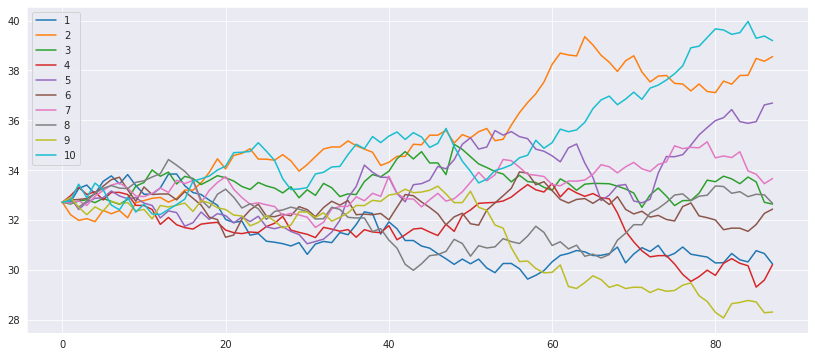

In [ ]:
allpaths_df= MCsim(S, T, mu, vol,  Np)

In [ ]:
allpaths_df['mean']=allpaths_df.mean(axis=1)

In [ ]:
mcfc=allpaths_df[['mean']][1:]

In [ ]:
mcfc.index=ts_test.index

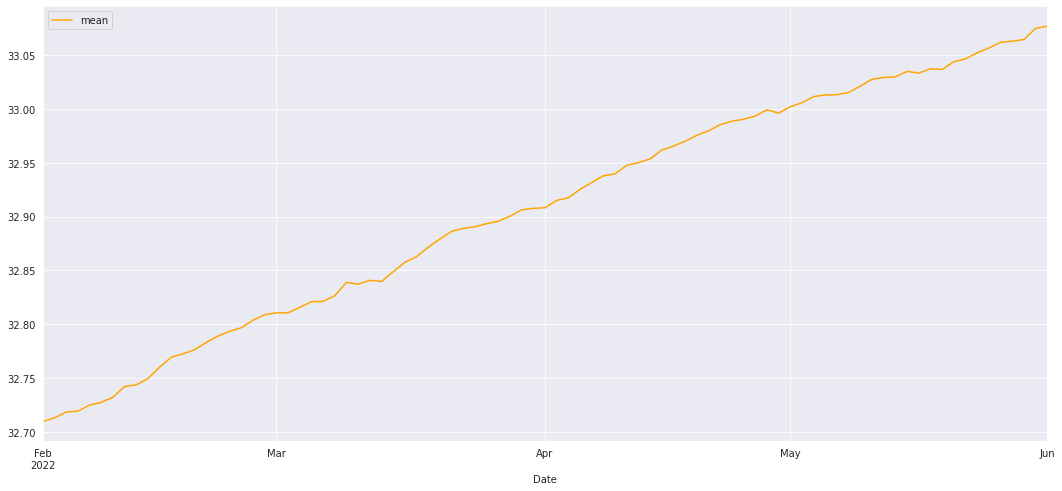

In [ ]:
mcfc.plot(color='orange')

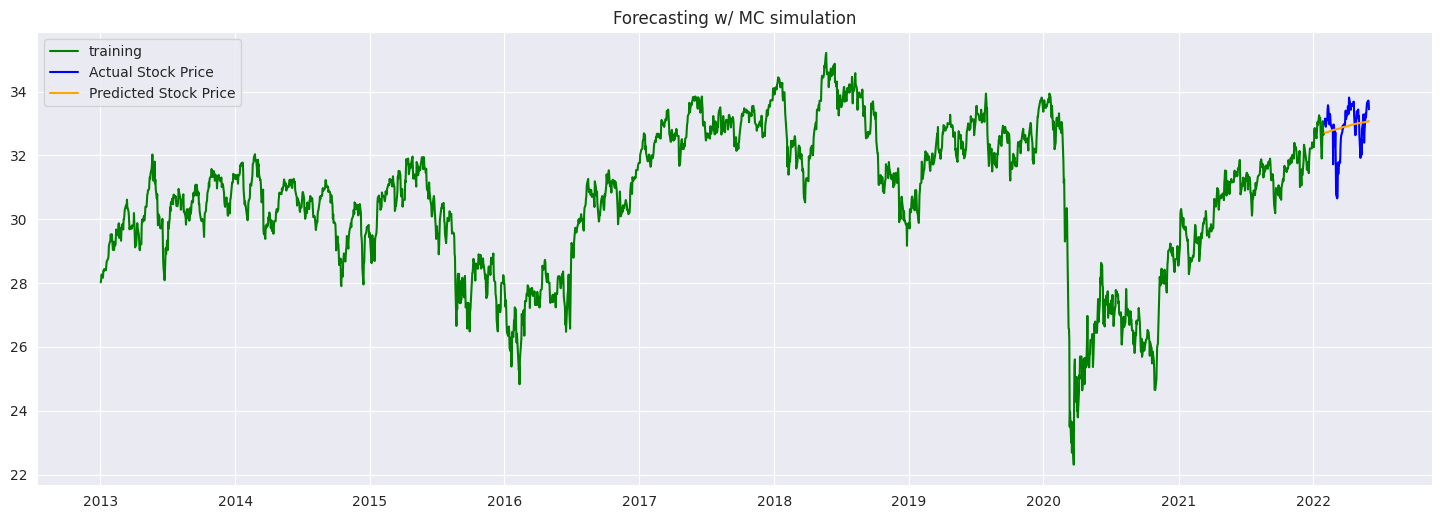

In [ ]:
plt.figure(figsize=(18,6), dpi=100)
plt.plot( (ts_train), color='green', label='training')
plt.plot( (ts_test), color = 'blue', label='Actual Stock Price')
plt.plot( mcfc, color = 'orange',label='Predicted Stock Price')
plt.title('Forecasting w/ MC simulation')
plt.legend(loc='best')
plt.show()

In [ ]:
# report performance
mse = mean_squared_error(ts_test, mcfc)
print('MSE: '+str(mse))
mae = mean_absolute_error(ts_test, mcfc)
print('MAE: '+str(mae))
rmse = np.sqrt(mean_squared_error(ts_test, mcfc))
print('RMSE: '+str(rmse))

results['Monte Carlo Simulations']=[mae, mse]

MSE: 0.445788718540071
MAE: 0.5078708246972398
RMSE: 0.6676741110302773


## Distribution of predictions for the last day

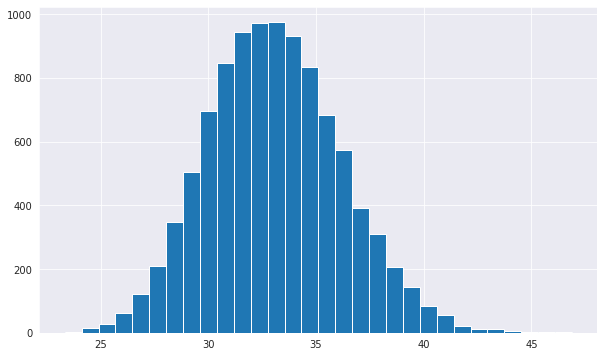

In [ ]:
allpaths_df.iloc[-1, 0:-1].hist(bins=30, figsize=(10,6))

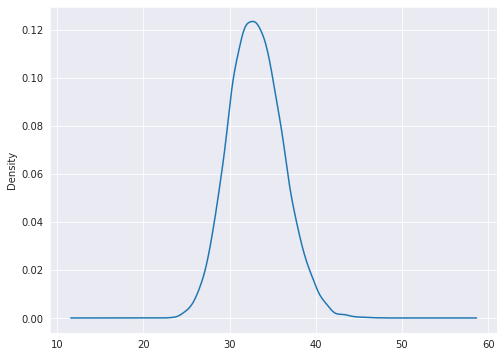

In [ ]:
allpaths_df.iloc[-1, 0:-1].plot(kind="kde", figsize=(8,6))

In [ ]:
# Mean
allpaths_df.iloc[-1, 0:-1].mean()

33.076832906118916

In [ ]:
# Sigma 
allpaths_df.iloc[-1, 0:-1].std()

3.1159190174100715

In [ ]:
# Actual Price
ts_test['Close'][-1]

33.44499969482422

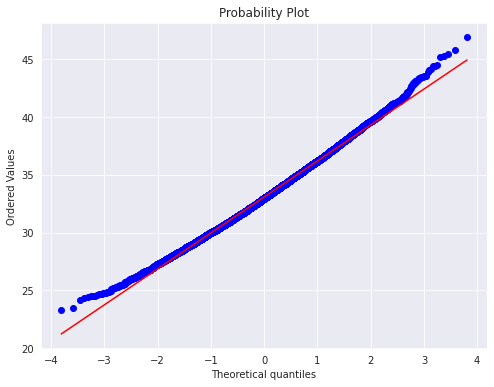

In [ ]:
plt.figure('QQ plot', figsize=(8,6));
stats.probplot(allpaths_df.iloc[-1, 0:-1], plot=plt);

# fbprophet

*Prophet is open source software released by Facebook's Core Data Science team.*

In [ ]:
#pip install fbprophet

In [ ]:
# check prophet version
import fbprophet
# print version number
print('Prophet %s' % fbprophet.__version__)

Prophet 0.7.1


In [ ]:
ts_train_fb=ts_train.reset_index()

ts_train_fb.columns=['ds', 'y']

ts_train_fb

ds          y
0    2013-01-02  28.025000
1    2013-01-03  28.094999
2    2013-01-04  28.270000
3    2013-01-07  28.209999
4    2013-01-08  28.170000
...         ...        ...
2364 2022-01-25  32.220001
2365 2022-01-26  32.724998
2366 2022-01-27  33.075001
2367 2022-01-28  32.639999
2368 2022-01-31  32.709999

[2369 rows x 2 columns]

In [ ]:
from fbprophet import Prophet

# define the model
model = Prophet(daily_seasonality=True)
# fit the model
model.fit(ts_train_fb )

In [ ]:
future = model.make_future_dataframe(periods=len(ts_test))
future.tail()

ds
2451 2022-04-24
2452 2022-04-25
2453 2022-04-26
2454 2022-04-27
2455 2022-04-28

In [ ]:
future.head()

ds
0 2013-01-02
1 2013-01-03
2 2013-01-04
3 2013-01-07
4 2013-01-08

In [ ]:
future['ds'].iloc[-len(ts_test): ]=ts_test.index
future=future[ future['ds']>= dt.datetime(2022,2,1)  ]
future.head()

ds
2369 2022-02-01
2370 2022-02-02
2371 2022-02-03
2372 2022-02-04
2373 2022-02-07

In [ ]:
future.tail()

ds
2451 2022-05-26
2452 2022-05-27
2453 2022-05-30
2454 2022-05-31
2455 2022-06-01

In [ ]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

ds       yhat  yhat_lower  yhat_upper
0 2022-02-01  33.162962   32.126334   34.134135
1 2022-02-02  33.196018   32.282287   34.201515
2 2022-02-03  33.185915   32.148496   34.214960
3 2022-02-04  33.205482   32.118746   34.180648
4 2022-02-07  33.294705   32.301623   34.317201

In [ ]:
fbfc=forecast[['ds', 'yhat']]
fbfc=fbfc.set_index('ds')
#fbfc=fbfc['2021-10':]

In [ ]:
fbfc

yhat
ds                   
2022-02-01  33.162962
2022-02-02  33.196018
2022-02-03  33.185915
2022-02-04  33.205482
2022-02-07  33.294705
...               ...
2022-05-26  35.315549
2022-05-27  35.326237
2022-05-30  35.342839
2022-05-31  35.369331
2022-06-01  35.379356

[87 rows x 1 columns]

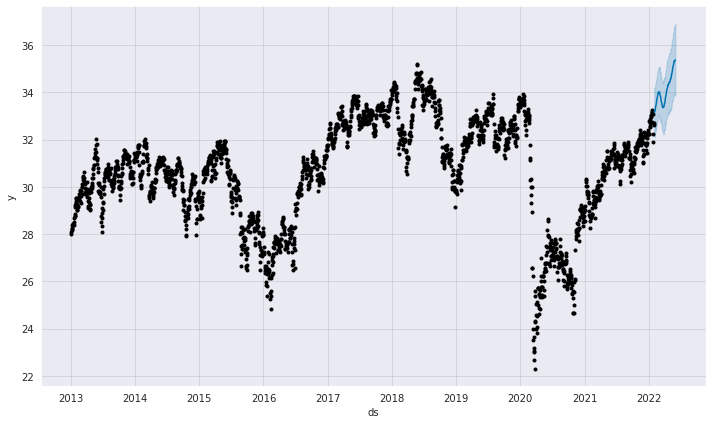

In [ ]:
fig1 = model.plot(forecast)


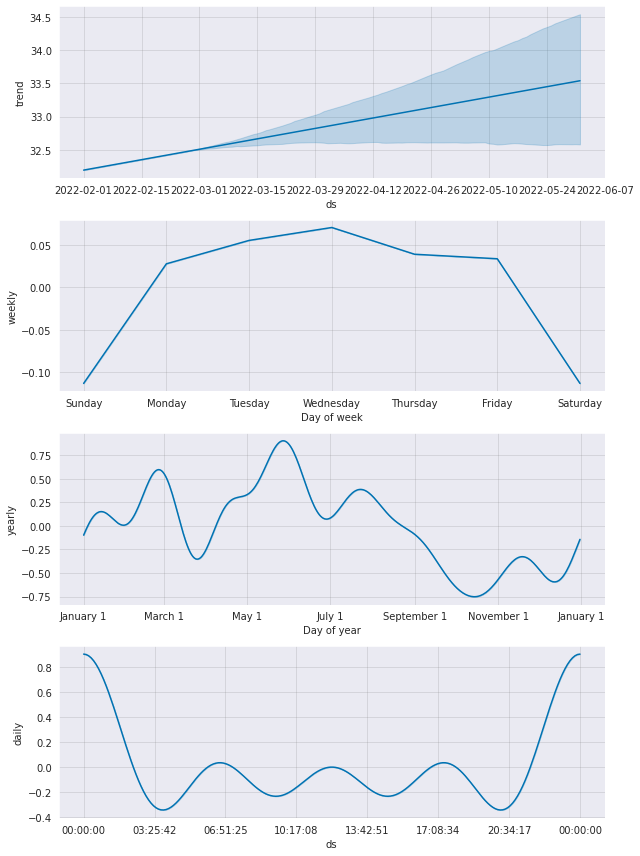

In [ ]:
fig2 = model.plot_components(forecast)


In [ ]:
from fbprophet.plot import plot_plotly, plot_components_plotly
#import plotly.graph_objects as go

plot_plotly(model, forecast)

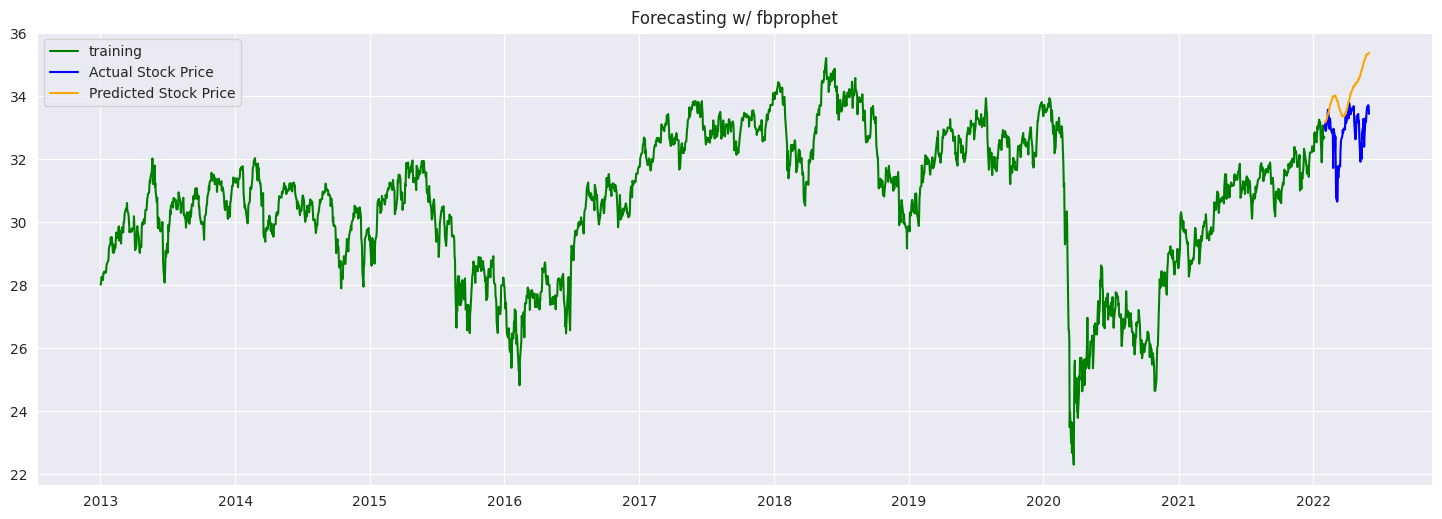

In [ ]:
plt.figure(figsize=(18,6), dpi=100)
plt.plot( ts_train, color='green', label='training')
plt.plot( ts_test, color = 'blue', label='Actual Stock Price')
plt.plot( fbfc, color = 'orange',label='Predicted Stock Price')
plt.title('Forecasting w/ fbprophet')
plt.legend(loc='best')
plt.show()

In [ ]:
# report performance
mse = mean_squared_error(ts_test, fbfc)
print('MSE: '+str(mse))
mae = mean_absolute_error(ts_test, fbfc)
print('MAE: '+str(mae))
rmse = np.sqrt(mean_squared_error(ts_test, fbfc))
print('RMSE: '+str(rmse))

results['fbprophet']=[mae, mse]

MSE: 2.1503593252597404
MAE: 1.1946959996569952
RMSE: 1.4664103536390285


# LSTM

and Preprocessing With 1D-Convolutional Layers.

In [ ]:
keras = tf.keras

In [ ]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    

def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

## 1 step ahead

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(
                                      list(ts_train.values.flatten())
                                      , window_size)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      batch_input_shape=[1, None, 1],
                      input_shape=[None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                   # batch_input_shape=[1, None, 1]
                    ),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])


In [ ]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [ ]:
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

reset_states = ResetStatesCallback()

optimizer = keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/100
78/78 [==============================] - 15s 17ms/step - loss: 41.8452 - mae: 42.3452 - lr: 1.0000e-08
Epoch 2/100
78/78 [==============================] - 1s 11ms/step - loss: 12.3170 - mae: 12.8046 - lr: 1.1220e-08
Epoch 3/100
78/78 [==============================] - 1s 8ms/step - loss: 4.5576 - mae: 5.0250 - lr: 1.2589e-08
Epoch 4/100
78/78 [==============================] - 1s 8ms/step - loss: 4.3228 - mae: 4.7806 - lr: 1.4125e-08
Epoch 5/100
78/78 [==============================] - 1s 8ms/step - loss: 4.1242 - mae: 4.5825 - lr: 1.5849e-08
Epoch 6/100
78/78 [==============================] - 1s 8ms/step - loss: 3.9446 - mae: 4.4026 - lr: 1.7783e-08
Epoch 7/100
78/78 [==============================] - 1s 8ms/step - loss: 3.7825 - mae: 4.2395 - lr: 1.9953e-08
Epoch 8/100
78/78 [==============================] - 1s 8ms/step - loss: 3.6693 - mae: 4.1345 - lr: 2.2387e-08
Epoch 9/100
78/78 [==============================] - 1s 8ms/step - loss: 3.5416 - mae: 4.0121 - lr: 2.511

(1e-08, 0.0001, 0.0, 30.0)

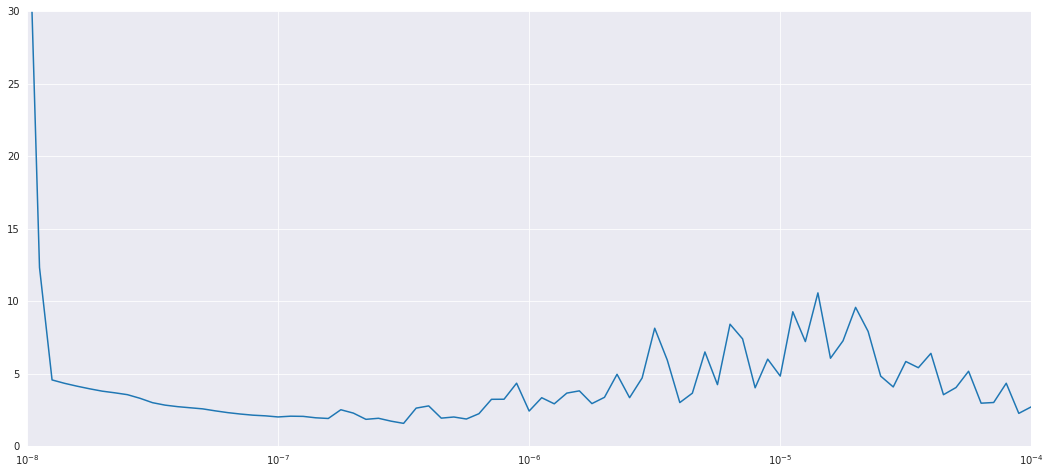

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])


In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30

train_set = sequential_window_dataset(     list(ts_train.values.flatten())     , window_size)
valid_set = sequential_window_dataset(        list(ts_test.values.flatten())            , window_size)

model = keras.models.Sequential([
     keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      batch_input_shape=[1, None, 1],
                      input_shape=[None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         #batch_input_shape=[1, None, 1]
                    ),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

reset_states = ResetStatesCallback()

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint_rnn1.h5", save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(patience=50)

# 500 epochs is better
model.fit(train_set, epochs=200,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/200
78/78 [==============================] - 16s 20ms/step - loss: 14.0136 - mae: 14.5072 - val_loss: 3.8813 - val_mae: 4.3803
Epoch 2/200
78/78 [==============================] - 1s 8ms/step - loss: 3.8463 - mae: 4.3200 - val_loss: 4.0770 - val_mae: 4.5748
Epoch 3/200
78/78 [==============================] - 1s 9ms/step - loss: 3.2089 - mae: 3.6724 - val_loss: 3.0358 - val_mae: 3.5098
Epoch 4/200
78/78 [==============================] - 1s 9ms/step - loss: 2.8868 - mae: 3.3442 - val_loss: 2.0222 - val_mae: 2.4786
Epoch 5/200
78/78 [==============================] - 1s 9ms/step - loss: 2.7105 - mae: 3.1657 - val_loss: 1.8557 - val_mae: 2.2840
Epoch 6/200
78/78 [==============================] - 1s 9ms/step - loss: 2.4976 - mae: 2.9509 - val_loss: 1.8046 - val_mae: 2.2413
Epoch 7/200
78/78 [==============================] - 1s 9ms/step - loss: 2.3336 - mae: 2.7824 - val_loss: 1.7724 - val_mae: 2.2148
Epoch 8/200
78/78 [==============================] - 1s 9ms/step - loss: 2.2167

In [ ]:
model = keras.models.load_model("my_checkpoint_rnn1.h5")

In [ ]:
rnn_forecast = model.predict( ts_recent.values.flatten()[np.newaxis, :, np.newaxis])
#rnn_forecast = rnn_forecast[0, len(ts_train)-1 :-1, 0]

In [ ]:
rnn_forecast.shape

(1, 2456, 1)

In [ ]:
rnn_forecast = rnn_forecast[0, len(ts_train)-1 :-1,0]
rnn_forecast.shape

(87,)

In [ ]:
len(ts_train)

2369

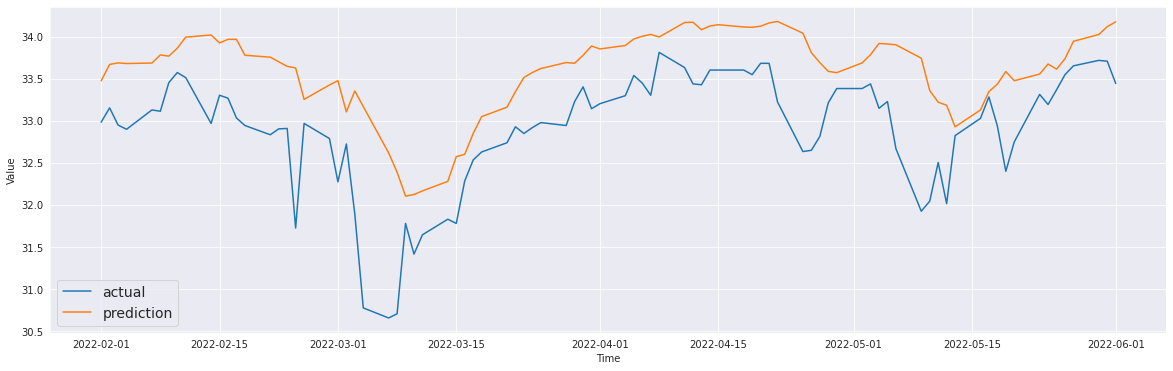

In [ ]:
plt.figure(figsize=(20, 6))
plot_series(ts_test.index, ts_test.values, label="actual")
plot_series(ts_test.index, rnn_forecast[:], label="prediction")

In [ ]:
rnn_forecast[-5:-1,]

array([33.73967 , 33.946796, 34.02836 , 34.121548], dtype=float32)

In [ ]:
ts.tail()

Close
Date                 
2022-05-26  33.549999
2022-05-27  33.654999
2022-05-30  33.720001
2022-05-31  33.709999
2022-06-01  33.445000

In [ ]:
mae=keras.metrics.mean_absolute_error(ts_test.values.flatten(), rnn_forecast).numpy()
mae

0.68303555

In [ ]:
mse=keras.metrics.mean_squared_error(ts_test.values.flatten(), rnn_forecast).numpy()
mse

0.6555153

In [ ]:
results['LSTM']=[mae, mse]



---




## 5 steps ahead 

In [ ]:
def window_dataset_atend(ts, window_size=30, target_length=1, batch_size=1):
    series=ts.values.flatten()
    series = tf.expand_dims(series, axis=-1)
    ds=tf.data.Dataset.from_tensor_slices(series)
    ds=ds.window(window_size+target_length, shift=1, drop_remainder=True)
    ds=ds.flat_map(lambda w: w.batch(window_size+target_length)  )
    ds=ds.map(lambda w: (w[:-target_length], w[-target_length:]) )
    ds=ds.shuffle(len(series))
    ds=ds.batch(batch_size).prefetch(1)
    #ds=ds.as_numpy_iterator()
    return ds

def window_dataset_eachstep(ts, window_size=30, target_length=1, batch_size=1):
    #series=ts.values.flatten()
    series=ts[:]
    series.columns=['0']
    for i in range(1,target_length+1):
        series[str(i)]=series['0'].shift(-i)
    series=series.iloc[:-target_length,:]
    #series = tf.expand_dims(series, axis=-1)
    ds=tf.data.Dataset.from_tensor_slices(series)
    ds=ds.window(window_size, shift=1, drop_remainder=True)
    ds=ds.flat_map(lambda w: w.batch(window_size)  )
    ds=ds.map(lambda w: (   tf.expand_dims(w[...,0], axis=-1)   , w[...,-target_length:]) )
    ds=ds.shuffle(len(series))
    ds=ds.batch(batch_size).prefetch(1)
    #ds=ds.as_numpy_iterator()
    return ds



In [ ]:
train_set=window_dataset_atend(ts_train, window_size=30, target_length=5)
valid_set=window_dataset_atend(ts_test,target_length=5)

In [ ]:
for x in train_set:
    print(x)
    break


(<tf.Tensor: shape=(1, 30, 1), dtype=float64, numpy=
array([[[31.27000046],
        [31.32999992],
        [31.29000092],
        [31.35000038],
        [31.54500008],
        [31.54500008],
        [31.54500008],
        [31.68250084],
        [31.71500015],
        [31.76749992],
        [31.76749992],
        [32.02249908],
        [32.07500076],
        [32.13000107],
        [32.18000031],
        [32.22000122],
        [32.43999863],
        [32.49000168],
        [32.51499939],
        [32.69499969],
        [32.64500046],
        [32.18500137],
        [32.29249954],
        [32.0625    ],
        [32.02249908],
        [31.81999969],
        [31.81999969],
        [31.86000061],
        [31.92499924],
        [32.02999878]]])>, <tf.Tensor: shape=(1, 5, 1), dtype=float64, numpy=
array([[[31.72500038],
        [31.64500046],
        [31.67000008],
        [31.81500053],
        [32.00500107]]])>)


In [ ]:
train_set=window_dataset_atend(ts_train, window_size=30, target_length=5)
valid_set=window_dataset_atend(ts_test,target_length=5)

np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(10, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(10, return_sequences=False),
   # keras.layers.TimeDistributed(keras.layers.Dense(5))
    keras.layers.Dense(5)
])

reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint_rnn5.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)


model.compile(loss="mse", optimizer='adam')

history = model.fit(train_set, epochs=50,
                    validation_data=valid_set
                    , callbacks=[early_stopping, model_checkpoint, reset_states]
                    )

Epoch 1/50
2335/2335 [==============================] - 24s 9ms/step - loss: 359.5033 - val_loss: 115.1878
Epoch 2/50
2335/2335 [==============================] - 15s 6ms/step - loss: 21.0485 - val_loss: 8.4046
Epoch 3/50
2335/2335 [==============================] - 15s 6ms/step - loss: 4.7829 - val_loss: 6.0693
Epoch 4/50
2335/2335 [==============================] - 15s 6ms/step - loss: 4.7589 - val_loss: 5.3035
Epoch 5/50
2335/2335 [==============================] - 17s 7ms/step - loss: 2.7606 - val_loss: 1.4883
Epoch 6/50
2335/2335 [==============================] - 15s 6ms/step - loss: 0.9603 - val_loss: 0.2862
Epoch 7/50
2335/2335 [==============================] - 15s 6ms/step - loss: 0.7884 - val_loss: 0.5089
Epoch 8/50
2335/2335 [==============================] - 15s 6ms/step - loss: 0.6239 - val_loss: 0.9043
Epoch 9/50
2335/2335 [==============================] - 15s 6ms/step - loss: 0.5582 - val_loss: 0.6927
Epoch 10/50
2335/2335 [==============================] - 15s 6ms/ste

In [ ]:
model = keras.models.load_model("my_checkpoint_rnn5.h5")

In [ ]:
rnn_forecast = model.predict( valid_set)


In [ ]:
rnn_forecast.shape

(53, 5)

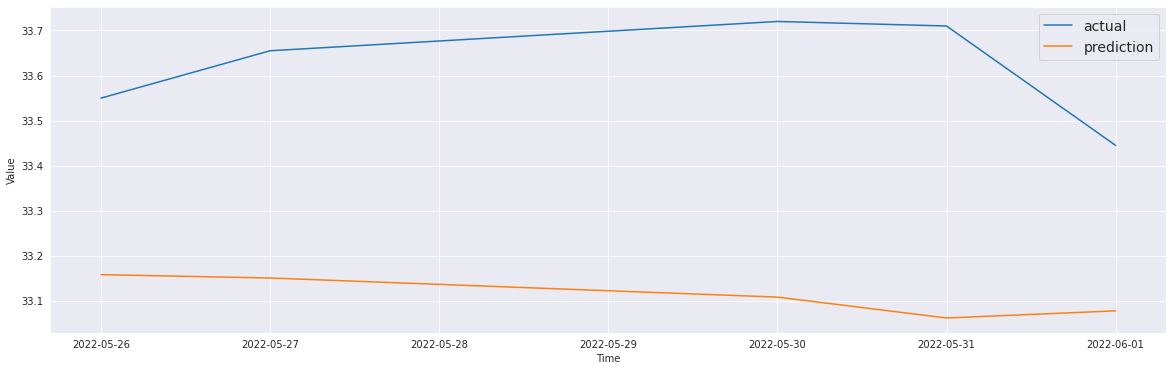

In [ ]:
plt.figure(figsize=(20, 6))
plot_series(ts_test[-5:].index, ts_test.values[-5:], label="actual")
plot_series(ts_test[-5:].index, rnn_forecast[-1,:], label="prediction")

```
# This is formatted as code
```

    def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

Another implementation of LSTM

In [ ]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [ ]:
train_set=window_dataset_eachstep(ts_train, window_size=30, target_length=5)
valid_set=window_dataset_eachstep(ts_test,target_length=5)


np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=False),
    #keras.layers.TimeDistributed(keras.layers.Dense(5))
    keras.layers.Dense(5)
])

reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint_rnn5b.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)


model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=[last_time_step_mse])

history = model.fit(train_set, epochs=20,
                    validation_data=valid_set
                    , callbacks=[early_stopping, model_checkpoint, reset_states]
                    )

# CNN w/ WaveNet architecture 

## 5 steps ahead

In [ ]:
train_set=window_dataset_eachstep(ts_train, window_size=30, target_length=5)
valid_set=window_dataset_eachstep(ts_test,target_length=5)


np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=5, kernel_size=1))

lr_schedule = keras.callbacks.LearningRateScheduler(    lambda epoch: 1e-4 * 10**(epoch / 30))

optimizer = keras.optimizers.Adam(learning_rate=3e-3)

model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])

history = model.fit(train_set, epochs=50,
                   validation_data=valid_set,
                    callbacks=[lr_schedule]
                    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Epoch 1/50
2335/2335 [==============================] - 14s 5ms/step - loss: 72.4840 - last_time_step_mse: 55.3074 - val_loss: 0.5747 - val_last_time_step_mse: 0.3207 - lr: 1.0000e-04
Epoch 2/50
2335/2335 [==============================] - 13s 5ms/step - loss: 0.4988 - last_time_step_mse: 0.4848 - val_loss: 0.7155 - val_last_time_step_mse: 0.4023 - lr: 1.0798e-04
Epoch 3/50
2335/2335 [==============================] - 12s 5ms/step - loss: 0.4257 - last_time_step_mse: 0.4383 - val_loss: 0.4860 - val_last_time_step_mse: 0.5359 - lr: 1.1659e-04
Epoch 4/50
2335/2335 [==============================] - 12s 5ms/step - loss: 0.3886 - last_time_step_mse: 0.4146 - val_loss: 0.6354 - val_last_time_step_mse: 0.6394 - lr: 1.2589e-04
Epoch 5/50
2335/2335 [==============================] - 13s 5ms/step - loss: 0.3551 - last_time_step_mse: 0.3711 - val_loss: 0.3647 - val_last_time_step_mse: 0.2637 - lr: 1.3594e-04
Epoch 6/50
2335/2335 [==============================] - 13s 5ms/step - loss: 0.3399 - la

(1e-05, 0.1, 0.0, 3.0)

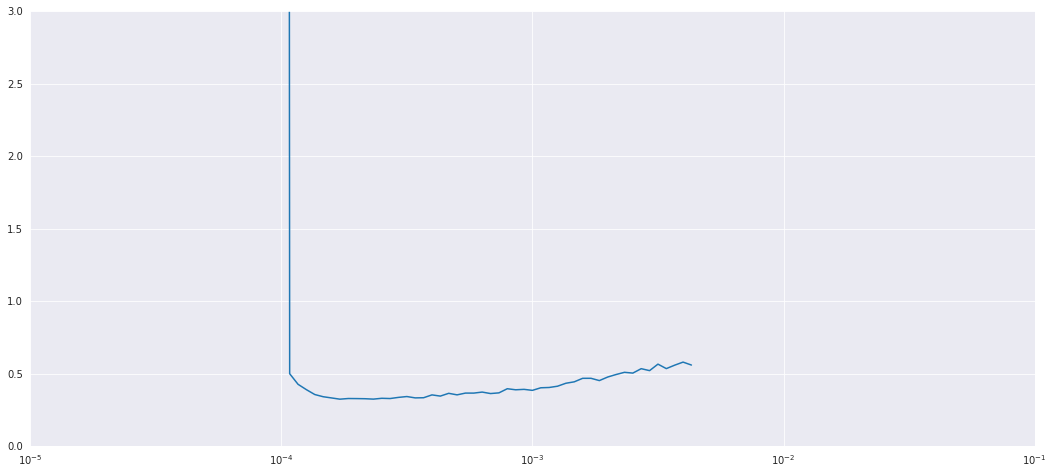

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 1e-1, 0, 3])


In [ ]:
train_set=window_dataset_eachstep(ts_train, window_size=30, target_length=5)
valid_set=window_dataset_eachstep(ts_test,target_length=5)


np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=5, kernel_size=1))


optimizer = keras.optimizers.Adam(learning_rate=2e-4)

model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])

history = model.fit(train_set, epochs=50,
                   validation_data=valid_set,
                   # callbacks=[lr_schedule]
                    )

2335/2335 [==============================] - 12s 5ms/step - loss: 0.4374 - last_time_step_mse: 0.4625 - val_loss: 0.4283 - val_last_time_step_mse: 0.2720
Epoch 3/50
2335/2335 [==============================] - 12s 5ms/step - loss: 0.3867 - last_time_step_mse: 0.4020 - val_loss: 0.3696 - val_last_time_step_mse: 0.2646
Epoch 4/50
2335/2335 [==============================] - 12s 5ms/step - loss: 0.3468 - last_time_step_mse: 0.3554 - val_loss: 0.3754 - val_last_time_step_mse: 0.3023
Epoch 5/50
2335/2335 [==============================] - 12s 5ms/step - loss: 0.3361 - last_time_step_mse: 0.3481 - val_loss: 0.4704 - val_last_time_step_mse: 0.5035
Epoch 6/50
2335/2335 [==============================] - 13s 5ms/step - loss: 0.3266 - last_time_step_mse: 0.3350 - val_loss: 0.3556 - val_last_time_step_mse: 0.2410
Epoch 7/50
2335/2335 [==============================] - 13s 5ms/step - loss: 0.3146 - last_time_step_mse: 0.3233 - val_loss: 0.4017 - val_last_time_step_mse: 0.2655
Epoch 8/50
2335/2335 

In [ ]:
wav5_forecast = model.predict( valid_set)


In [ ]:
wav5_forecast.shape

(53, 30, 5)

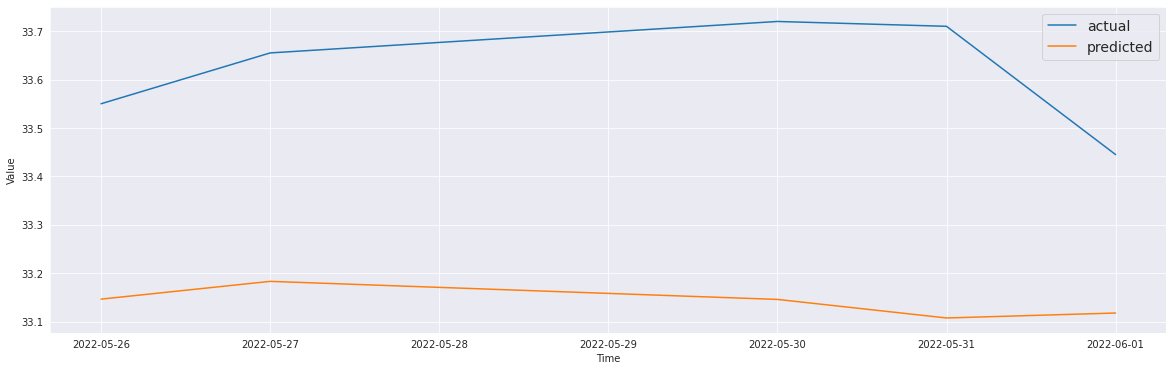

In [ ]:
plt.figure(figsize=(20, 6))
plot_series(ts_test[-5:].index, ts_test.values[-5:], label='actual')
plot_series(ts_test[-5:].index, wav5_forecast[-1,-1,:], label='predicted')

## 1 step ahead

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30

train_set = sequential_window_dataset(     list(ts_train.values.flatten())     , window_size)
valid_set = sequential_window_dataset(        list(ts_test.values.flatten())            , window_size)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, 
                                  kernel_size=2, 
                                  padding="causal",
                                  activation="relu", 
                                  dilation_rate=rate))
    
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))

optimizer = keras.optimizers.Adam(learning_rate=3e-3)

model.compile(loss='mse',
              optimizer=optimizer, 
              metrics=['mae'])

history = model.fit(train_set, epochs=70,
                   validation_data=valid_set,
                    callbacks=[lr_schedule]
                    )

Epoch 1/70
78/78 [==============================] - 2s 12ms/step - loss: 873.2555 - mae: 29.4635 - val_loss: 908.8163 - val_mae: 30.0973 - lr: 1.0000e-04
Epoch 2/70
78/78 [==============================] - 0s 6ms/step - loss: 561.8823 - mae: 22.6741 - val_loss: 304.6600 - val_mae: 13.4442 - lr: 1.0798e-04
Epoch 3/70
78/78 [==============================] - 0s 6ms/step - loss: 196.1217 - mae: 10.6045 - val_loss: 179.3395 - val_mae: 9.9377 - lr: 1.1659e-04
Epoch 4/70
78/78 [==============================] - 0s 6ms/step - loss: 113.8755 - mae: 7.3106 - val_loss: 89.6403 - val_mae: 5.8733 - lr: 1.2589e-04
Epoch 5/70
78/78 [==============================] - 0s 6ms/step - loss: 51.4598 - mae: 3.8083 - val_loss: 39.5050 - val_mae: 3.0246 - lr: 1.3594e-04
Epoch 6/70
78/78 [==============================] - 0s 6ms/step - loss: 25.4771 - mae: 2.4898 - val_loss: 20.6713 - val_mae: 2.1322 - lr: 1.4678e-04
Epoch 7/70
78/78 [==============================] - 0s 6ms/step - loss: 12.9755 - mae: 1.8867

(0.0001, 0.1, 0.0, 30.0)

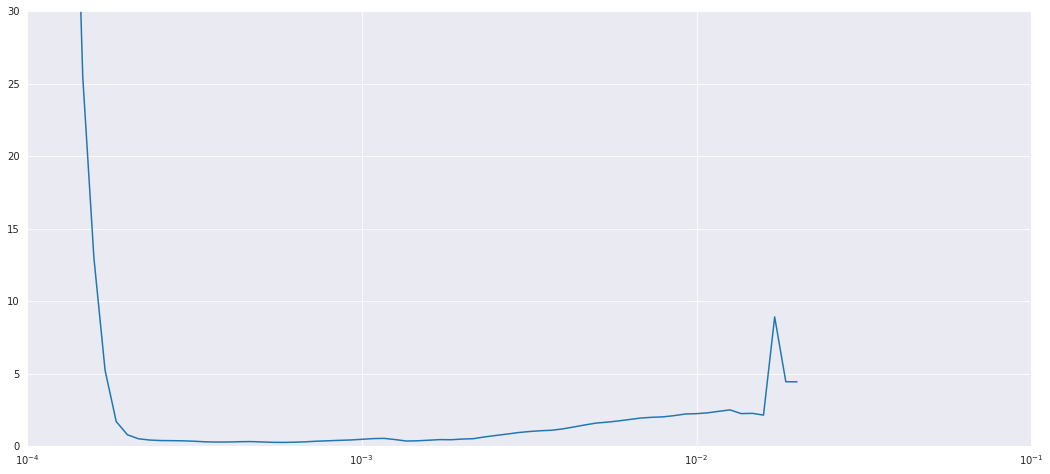

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 30])

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30

train_set = sequential_window_dataset(     list(ts_train.values.flatten())     , window_size)
valid_set = sequential_window_dataset(        list(ts_test.values.flatten())            , window_size)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, 
                                  kernel_size=2, 
                                  padding="causal",
                                  activation="relu", 
                                  dilation_rate=rate))
    
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))


optimizer = keras.optimizers.Adam(learning_rate=6.5e-4)

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint_wvn1.h5", save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(patience=50)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer, 
              metrics='mae')

history = model.fit(train_set, epochs=200,
                   validation_data=valid_set,
                     callbacks=[early_stopping, model_checkpoint])
                    

Epoch 1/200
78/78 [==============================] - 2s 13ms/step - loss: 15.4387 - mae: 15.9210 - val_loss: 5.6343 - val_mae: 6.1119
Epoch 2/200
78/78 [==============================] - 1s 6ms/step - loss: 2.0728 - mae: 2.4743 - val_loss: 1.0405 - val_mae: 1.4143
Epoch 3/200
78/78 [==============================] - 0s 6ms/step - loss: 0.5304 - mae: 0.8852 - val_loss: 0.2479 - val_mae: 0.5570
Epoch 4/200
78/78 [==============================] - 0s 6ms/step - loss: 0.2560 - mae: 0.5779 - val_loss: 0.2602 - val_mae: 0.5974
Epoch 5/200
78/78 [==============================] - 0s 6ms/step - loss: 0.2495 - mae: 0.5727 - val_loss: 0.2651 - val_mae: 0.6139
Epoch 6/200
78/78 [==============================] - 0s 6ms/step - loss: 0.2462 - mae: 0.5704 - val_loss: 0.2690 - val_mae: 0.6271
Epoch 7/200
78/78 [==============================] - 0s 6ms/step - loss: 0.2419 - mae: 0.5655 - val_loss: 0.2681 - val_mae: 0.6295
Epoch 8/200
78/78 [==============================] - 0s 6ms/step - loss: 0.2381 

In [ ]:
model = keras.models.load_model("my_checkpoint_wvn1.h5")

In [ ]:
wavenet_forecast = model.predict( ts_recent.values.flatten()[np.newaxis, :, np.newaxis])
#rnn_forecast = rnn_forecast[0, len(ts_train)-1 :-1, 0]

In [ ]:
wavenet_forecast.shape

(1, 2456, 1)

In [ ]:
wavenet_forecast = wavenet_forecast[0, len(ts_train)-1 :-1,0]
wavenet_forecast.shape

(87,)

In [ ]:
len(ts_train)

2369

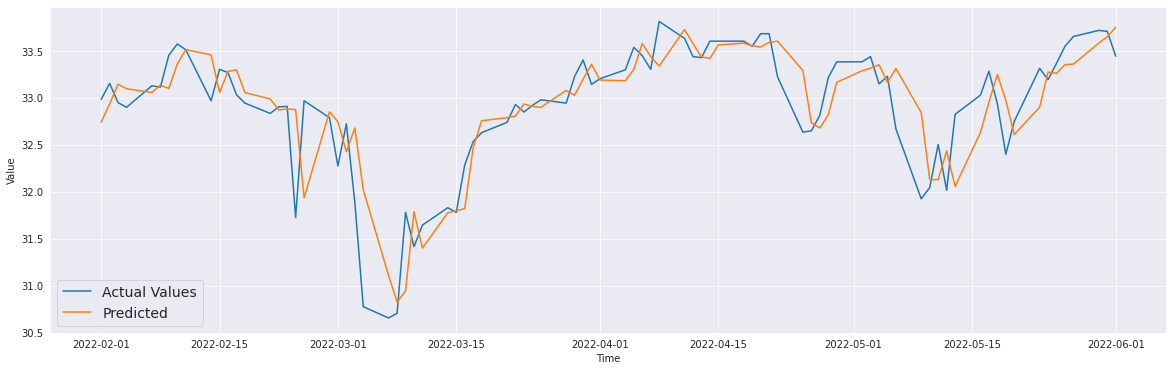

In [ ]:
plt.figure(figsize=(20, 6))
plot_series(ts_test.index, ts_test.values, label='Actual Values')
plot_series(ts_test.index, wavenet_forecast[:], label='Predicted')

In [ ]:
wavenet_forecast[-5:-1,]

array([33.354336, 33.360912, 33.58477 , 33.652016], dtype=float32)

In [ ]:
ts.tail()

Close
Date                 
2022-05-26  33.549999
2022-05-27  33.654999
2022-05-30  33.720001
2022-05-31  33.709999
2022-06-01  33.445000

In [ ]:
mae=keras.metrics.mean_absolute_error(ts_test.values.flatten(), wavenet_forecast).numpy()
mae

0.25876102

In [ ]:
mse=keras.metrics.mean_squared_error(ts_test.values.flatten(), wavenet_forecast).numpy()
mse

0.13569842

In [ ]:
results['WaveNet']=[mae, mse]

# III. Results/ Comments

In [ ]:
results_df=pd.DataFrame(results)
results_df.index=['MAE', 'MSE']
results_df=results_df.T
results_df.sort_values(by=['MAE'], inplace=True)

In [9]:
results_df

MAE       MSE
WaveNet                       0.258761  0.135698
Naive (daily updated)         0.274821  0.150616
Monte Carlo Simulations       0.507871  0.445789
ARIMA(1,1,1)                  0.576920  0.505175
Naive (Baseline)              0.583621  0.510425
LSTM                          0.683036  0.655515
Triple Exponential Smoothing  0.719249  0.894361
fbprophet                     1.194696  2.150359

Remarks: 

*   The "Naive(daily updated)" model has knowledge of the true price value of the previous day. For this reason, it is not comparable with the other models but it still offers a very high benchmark for other models to beat. 
*   The WaveNet and LSTM algorithms are chosen by ModelCheckpoint based on the best predictions on the validation set, even though are trained exclusively on the training set. Therefore, the table above only gives us a rough idea of the performance of each  method. We could have made it more accurate by setting " monitor='loss' "  but for the purposes of this notebook this wasn't important.

*   The WaveNet beats others, as expected. Also, RNN/LSTM's score could be improved by better training. 